# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

#[Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.
3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import os
import re
import nltk
from google.colab import drive
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import gensim.downloader as api
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, GlobalMaxPooling1D, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
import random
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
import torch
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from torch.utils.data import DataLoader
import itertools
import os


In [ ]:
drive.mount('/content/drive')

#Load the data from JSON files
train_df = pd.read_json('/content/drive/My Drive/NLP/1/training.json')
val_df = pd.read_json('/content/drive/My Drive/NLP/1/validation.json')
test_df = pd.read_json('/content/drive/My Drive/NLP/1/test.json')

#Generate hard labels using majority voting
def generate_hard_label(labels):
    """Generate hard labels using majority voting.
       Returns 'YES', 'NO', or None if there is no majority."""
    label_counts = Counter(labels)
    if label_counts['YES'] > label_counts['NO']:
        return 'YES'
    elif label_counts['NO'] > label_counts['YES']:
        return 'NO'
    else:
        return None  # No majority
train_df = train_df.transpose()
test_df = test_df.transpose()
val_df = val_df.transpose()


train_df['hard_label_task1'] = [generate_hard_label(labels) for labels in train_df['labels_task1']]
val_df['hard_label_task1'] = [generate_hard_label(labels) for labels in val_df['labels_task1']]
test_df['hard_label_task1'] = [generate_hard_label(labels) for labels in test_df['labels_task1']]

#Remove rows with no majority
train_df = train_df.dropna(subset=['hard_label_task1'])
val_df = val_df.dropna(subset=['hard_label_task1'])
test_df = test_df.dropna(subset=['hard_label_task1'])

#Filter for English tweets only
train_df = train_df[train_df['lang'] == 'en']
val_df = val_df[val_df['lang'] == 'en']
test_df = test_df[test_df['lang'] == 'en']

#Select only relevant columns
train_df = train_df[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]
val_df = val_df[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]
test_df = test_df[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]

#Encode labels ('YES' to 1, 'NO' to 0)
label_mapping = {'YES': 1, 'NO': 0}
train_df['hard_label_task1'] = train_df['hard_label_task1'].map(label_mapping)
val_df['hard_label_task1'] = val_df['hard_label_task1'].map(label_mapping)
test_df['hard_label_task1'] = test_df['hard_label_task1'].map(label_mapping)


print("Train DataFrame:\n", train_df.head())
print("\nValidation DataFrame:\n", val_df.head())
print("\nTest DataFrame:\n", test_df.head())


Mounted at /content/drive
Train DataFrame:
        id_EXIST lang                                              tweet  \
200002   200002   en  Writing a uni essay in my local pub with a cof...   
200003   200003   en  @UniversalORL it is 2021 not 1921. I dont appr...   
200006   200006   en  According to a customer I have plenty of time ...   
200007   200007   en  So only 'blokes' drink beer? Sorry, but if you...   
200008   200008   en  New to the shelves this week - looking forward...   

        hard_label_task1  
200002                 1  
200003                 1  
200006                 1  
200007                 1  
200008                 0  

Validation DataFrame:
        id_EXIST lang                                              tweet  \
400001   400001   en  @Mike_Fabricant “You should smile more, love. ...   
400002   400002   en  @BBCWomansHour @LabWomenDec @EverydaySexism Sh...   
400003   400003   en  #everydaysexism Some man moving my suitcase in...   
400004   400004   e

# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')


def preprocess_tweet(text):

    #remove emojis
    emoji_pattern = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Make text lowercase
    text = text.lower()

    # Remove hashtags
    text = re.sub(r'#\w+', '', text)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove URLs (http/https)
    text = re.sub(r'http[s]?://\S+', '', text)

    # Remove any word that includes '.com'
    text = re.sub(r'\b\w*\.com\w*\b', '', text)

    # Remove specific quote characters
    text = re.sub(r'[“”‘’]', '', text)

    # Remove special characters and symbols (keeping only letters, digits, whitespace)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)

    # Replace standalone numbers with <num>
    text = re.sub(r'\b\d+\b', '<num>', text)

    return text.strip()

# Mapping from NLTK POS tags to WordNet POS tags
def word_net_key(pos_tag_str):
    if pos_tag_str.startswith('J'):
        return wordnet.ADJ
    elif pos_tag_str.startswith('V'):
        return wordnet.VERB
    elif pos_tag_str.startswith('N'):
        return wordnet.NOUN
    elif pos_tag_str.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Lemmatization
def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    tokenizer = WhitespaceTokenizer()
    tokens = tokenizer.tokenize(text)
    tagged = pos_tag(tokens)
    lemmatized_words = [lemmatizer.lemmatize(word, word_net_key(tag)) for word, tag in tagged]
    return ' '.join(lemmatized_words)

# Define the preprocessing pipeline
PREPROCESSING_PIPELINE = [
    preprocess_tweet,
    lemmatization,
]

# Apply the preprocessing pipeline to a text
def apply_pipeline(text, pipeline):
    for step in pipeline:
        text = step(text)
    return text

# Example usage
tweet = "Hey @user! Check out this cool 22 link: Http://example.com #Amazing testing.com/hello 😄 20"
print("Original Tweet: ",tweet)
processed_tweet = tweet
for step in PREPROCESSING_PIPELINE:
    processed_tweet = step(processed_tweet)

print("processed tweet: ",processed_tweet)


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Original Tweet:  Hey @user! Check out this cool 22 link: Http://example.com #Amazing testing.com/hello 😄 20
processed tweet:  hey check out this cool <num> link hello <num>


In [ ]:
#apply preprocessing to the dataframes
train_df['processed_tweet'] = train_df['tweet'].apply(lambda x: apply_pipeline(x, PREPROCESSING_PIPELINE))
val_df['processed_tweet'] = val_df['tweet'].apply(lambda x: apply_pipeline(x, PREPROCESSING_PIPELINE))
test_df['processed_tweet'] = test_df['tweet'].apply(lambda x: apply_pipeline(x, PREPROCESSING_PIPELINE))

In [ ]:
train_df.head()

,id_EXIST,lang,tweet,hard_label_task1,processed_tweet
200002,200002,en,Writing a uni essay in my local pub with a cof...,1,write a uni essay in my local pub with a coffe...
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1,it be <num> not <num> i dont appreciate that o...
200006,200006,en,According to a customer I have plenty of time ...,1,accord to a customer i have plenty of time to ...
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1,so only blokes drink beer sorry but if you are...
200008,200008,en,New to the shelves this week - looking forward...,0,new to the shelf this week look forward to rea...


# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

In [ ]:
# Load the GloVe embeddings
def load_glove_embeddings(dimension=50):
    """
    Downloads the GloVe embeddings of the specified dimension.
    Possible values are typically 50, 100, 200, 300 for the 'glove-wiki-gigaword' sets.
    """
    model_name = f"glove-wiki-gigaword-{dimension}"
    glove_model = api.load(model_name)
    return glove_model

# building the vocabulary
def build_vocabulary_and_embeddings(train_df, val_df, test_df, embedding_dim=50, seed=42, if_union=False):

    # Load GloVe embeddings
    glove = load_glove_embeddings(dimension=embedding_dim)

    # Extract tokens from datasets
    train_tokens = [tweet.split() for tweet in train_df['processed_tweet']]
    val_tokens = [tweet.split() for tweet in val_df['processed_tweet']]
    test_tokens = [tweet.split() for tweet in test_df['processed_tweet']]

    # create set of unique tokens
    train_vocab = set([token for tweet in train_tokens for token in tweet])
    val_vocab = set([token for tweet in val_tokens for token in tweet])
    test_vocab = set([token for tweet in test_tokens for token in tweet])

    full_glove_vocab = set(glove.key_to_index.keys())

    # if vocabulary is union of train and glove
    if if_union:
        vocabulary = train_vocab.union(full_glove_vocab)
    else:
        vocabulary = train_vocab

    #special tokens
    PAD_TOKEN = "[PAD]"
    UNK_TOKEN = "[UNK]"
    vocabulary = {PAD_TOKEN, UNK_TOKEN}.union(vocabulary)

    #vocabulary size
    print("Vocabulary size:", len(vocabulary))

    # Create mappings
    word_to_index = {}
    index_to_word = []

    vocabulary = list(vocabulary)
    pad_index = vocabulary.index(PAD_TOKEN)

    #move the pad token to the front
    vocabulary.pop(pad_index)
    vocabulary.insert(0, PAD_TOKEN)

    # Assign indices
    for idx, word in enumerate(vocabulary):
        word_to_index[word] = idx
        index_to_word.append(word)

    print("PAD",word_to_index[PAD_TOKEN])
    print("UNK",word_to_index[UNK_TOKEN])


    # Initialize embeddings with a normal distribution for all words
    np.random.seed(seed)
    embeddings_matrix = np.random.normal(scale=0.01, size=(len(vocabulary), embedding_dim)).astype(np.float32)

    # For words in GloVe, use GloVe embedding
    for word in vocabulary:
        if word in glove:
            embeddings_matrix[word_to_index[word]] = glove[word]

    # Handle PAD_TOKEN embedding
    embeddings_matrix[word_to_index[PAD_TOKEN]] = np.zeros((embedding_dim,), dtype=np.float32)

    # Compute mean embedding (for UNK) as the mean of known (GloVe) embeddings
    glove_indices = [word_to_index[w] for w in vocabulary if w in glove]
    mean_embedding = np.mean(embeddings_matrix[glove_indices], axis=0)
    embeddings_matrix[word_to_index[UNK_TOKEN]] = mean_embedding

    return word_to_index, index_to_word, embeddings_matrix

# encode_text function which encodes a list of tokens into indices
def encode_text(tokens, word_to_index, unk_token="[UNK]", pad_token="[PAD]", max_length=None):
    """
    Encode a list of tokens into indices.
    If max_length is specified, pad/truncate sequences to that length.
    """
    encoded = []
    for t in tokens:
        if t in word_to_index:
            encoded.append(word_to_index[t])
        else:
            # OOV token not in vocabulary gets UNK
            encoded.append(word_to_index[unk_token])
    if max_length is not None:
        # Padding
        if len(encoded) < max_length:
            encoded = encoded + [word_to_index[pad_token]] * (max_length - len(encoded))
        else:
            encoded = encoded[:max_length]
    return encoded

#build vocabulary and embeddings
embedding_dim = 50
word_to_index, index_to_word, embeddings_matrix = build_vocabulary_and_embeddings(train_df, val_df, test_df, embedding_dim=embedding_dim, if_union=True)

# maximum length of tweets in the training set
def max_length(tokens):
    return max([len(tweet.split()) for tweet in tokens])
print("Max length of tweets:", max_length(train_df['processed_tweet']))

# Define a max_length if you want fixed-length sequences
max_length = max_length(train_df['processed_tweet'])


[==================================================] 100.0% 66.0/66.0MB downloaded
Vocabulary size: 401836
PAD 0
UNK 292024
Max length of tweets: 60


In [ ]:
# Add a column with encoded tweets
train_df['encoded'] = train_df['processed_tweet'].apply(lambda x: encode_text(x.split(), word_to_index, max_length=max_length))
val_df['encoded'] = val_df['processed_tweet'].apply(lambda x: encode_text(x.split(), word_to_index, max_length=max_length))
test_df['encoded'] = test_df['processed_tweet'].apply(lambda x: encode_text(x.split(), word_to_index, max_length=max_length))

In [ ]:
train_df.head()

,id_EXIST,lang,tweet,hard_label_task1,processed_tweet,encoded
200002,200002,en,Writing a uni essay in my local pub with a cof...,1,write a uni essay in my local pub with a coffe...,"[221039, 207264, 273429, 281544, 83132, 55638,..."
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1,it be <num> not <num> i dont appreciate that o...,"[96289, 211341, 350681, 68768, 350681, 401646,..."
200006,200006,en,According to a customer I have plenty of time ...,1,accord to a customer i have plenty of time to ...,"[401552, 124225, 207264, 273802, 401646, 84338..."
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1,so only blokes drink beer sorry but if you are...,"[287802, 312222, 184688, 195374, 103536, 10057..."
200008,200008,en,New to the shelves this week - looking forward...,0,new to the shelf this week look forward to rea...,"[348334, 124225, 272145, 238079, 394725, 1728,..."


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

In [ ]:
# embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
#                                       output_dim=embedding_dimension,
#                                       weights=[embedding_matrix],
#                                       mask_zero=True,                   # automatically masks padding tokens
#                                       name='encoder_embedding')

### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

In [ ]:
#setting seed
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

#create batches
def create_dataset(df, batch_size=32):
    X = np.stack(df['encoded'].values, axis=0)
    y = df['hard_label_task1'].values
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(len(X)).batch(batch_size)
    return dataset

#evaluate the model
def evaluate_model(model, dataset, classifiation_threshold=0.5):
    y_true = []
    y_pred = []
    for X_batch, y_batch in dataset:
        preds = model.predict(X_batch, verbose=0)
        predicted_labels = (preds > classifiation_threshold).astype(int)
        y_true.extend(y_batch.numpy())
        y_pred.extend(predicted_labels.flatten())
    # Compute macro-F1
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1


In [ ]:
# Model Definitions

#Baseline model : One LSTM layer
def build_baseline_model(vocab_size, embedding_dim, embedding_matrix, max_length=max_length, lstm_units=64, trainable_emb=False, dropout_rate=0.3, recurrent_dropout_rate=0.3):
    model = Sequential(name='Baseline_BiLSTM_Model')

    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_length,
                        mask_zero=True,
                        trainable=trainable_emb,
                        name='encoder_embedding'))

    model.add(Bidirectional(LSTM(units=lstm_units,
                                 return_sequences=False,
                                 dropout=dropout_rate,
                                 recurrent_dropout=recurrent_dropout_rate),
                            name='bidirectional_lstm'))

    model.add(Dense(1, activation='sigmoid', name='output_layer'))
    return model

#Model 1 : Two LSTM layers
def build_model_1(vocab_size, embedding_dim, embedding_matrix, lstm_units=64, trainable_emb=False, dropout_rate=0.3, recurrent_dropout_rate=0.3):

    model = Sequential(name='Baseline_BiLSTM_Model')

    model.add(Embedding(input_dim=vocab_size,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_length,
                        mask_zero=True,
                        trainable=trainable_emb,
                        name='encoder_embedding'))

    model.add(Bidirectional(LSTM(units=lstm_units,
                                return_sequences=True,
                                dropout=dropout_rate,
                                recurrent_dropout=recurrent_dropout_rate),
                            name='bidirectional_lstm'))

    model.add(Bidirectional(LSTM(units=lstm_units,
                                return_sequences=False,
                                dropout=dropout_rate,
                                recurrent_dropout=recurrent_dropout_rate),
                            name='bidirectional_lstm_2'))

    model.add(Dense(1, activation='sigmoid', name='output_layer'))
    return model



# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

##Hyperparameter Tuning of Baseline Model

In [ ]:
# Hyperparameter tuning for Baseline model
# grid search for hyperparameter tuning

# Define the hyperparameters to tune
hyperparameters = {
    'lstm_units': [64, 256],
    'lr': [1e-3],
    'trainable_emb': [False,True],
    'epochs': [12],
    'batch_size': [32, 64],
    'classifiation_threshold': [0.5],
    'dropout_rate': [0.3],
    'recurrent_dropout_rate': [0.3]
}
vocab_size = embeddings_matrix.shape[0]
embedding_dimension = embeddings_matrix.shape[1]

best_f1_score_baseline = -np.inf
best_params_baseline = None

for lstm_unit in hyperparameters['lstm_units']:
    for lr in hyperparameters['lr']:
        for trainable_emb in hyperparameters['trainable_emb']:
            for epochs in hyperparameters['epochs']:
                for batch_size in hyperparameters['batch_size']:
                    for classifiation_threshold in hyperparameters['classifiation_threshold']:
                        for dropout_rate in hyperparameters['dropout_rate']:
                            for recurrent_dropout_rate in hyperparameters['recurrent_dropout_rate']:
                                seeds = [42, 123, 2024]
                                all_val_f1s = []
                                for seed in seeds:
                                  set_seed(seed)
                                  model = build_baseline_model(
                                      vocab_size=vocab_size,
                                      embedding_dim=embedding_dimension,
                                      embedding_matrix=embeddings_matrix,
                                      lstm_units=lstm_unit,
                                      trainable_emb=trainable_emb,
                                      dropout_rate=dropout_rate,
                                      recurrent_dropout_rate=recurrent_dropout_rate
                                  )
                                  model.compile(
                                      loss='binary_crossentropy',
                                      optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                                      metrics=['accuracy']
                                  )

                                  train_dataset = create_dataset(train_df, batch_size=batch_size)
                                  val_dataset = create_dataset(val_df, batch_size=batch_size)
                                  test_dataset = create_dataset(test_df, batch_size=batch_size)

                                  model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose=1)
                                  val_f1_model_baseline = evaluate_model(model, val_dataset, classifiation_threshold=classifiation_threshold)
                                  all_val_f1s.append(val_f1_model_baseline)

                                val_f1_mean = np.mean(all_val_f1s)
                                val_f1_std = np.std(all_val_f1s)

                                print(f"Model Baseline -> Val F1 (mean ± std): {val_f1_mean:.4f} ± {val_f1_std:.4f}")
                                # Update best parameters
                                if val_f1_mean > best_f1_score_baseline:
                                    best_f1_score_baseline = val_f1_mean
                                    best_params_baseline = {
                                        'lstm_units': lstm_unit,
                                        'lr': lr,
                                        'trainable_emb': trainable_emb,
                                        'epochs': epochs,
                                        'batch_size': batch_size,
                                        'classifiation_threshold': classifiation_threshold,
                                        'dropout_rate': dropout_rate,
                                        'recurrent_dropout_rate': recurrent_dropout_rate
                                    }



Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.5928 - loss: 0.6684 - val_accuracy: 0.6582 - val_loss: 0.6442
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.6607 - loss: 0.6211 - val_accuracy: 0.7152 - val_loss: 0.5936
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.6805 - loss: 0.5888 - val_accuracy: 0.7025 - val_loss: 0.5669
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.7016 - loss: 0.5749 - val_accuracy: 0.6962 - val_loss: 0.5885
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.6868 - loss: 0.5784 - val_accuracy: 0.7025 - val_loss: 0.5824
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 153ms/step - accuracy: 0.7182 - loss: 0.5447 - val_accuracy: 0.7025 - val_loss: 0.5646
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.7260 - loss: 0.5438 - val_accuracy: 0.7278 - val_loss: 0.5365
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.7333 - loss: 0.5225 - val_accuracy: 0.740

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 0.6034 - loss: 0.6709 - val_accuracy: 0.6709 - val_loss: 0.6221
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 152ms/step - accuracy: 0.6567 - loss: 0.6188 - val_accuracy: 0.7215 - val_loss: 0.5760
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - accuracy: 0.6833 - loss: 0.5907 - val_accuracy: 0.7342 - val_loss: 0.5623
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.6910 - loss: 0.5787 - val_accuracy: 0.7468 - val_loss: 0.5439
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.6969 - loss: 0.5620 - val_accuracy: 0.7152 - val_loss: 0.5545
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.7246 - loss: 0.5363 - val_accuracy: 0.7025 - val_loss: 0.5430
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.7240 - loss: 0.5405 - val_accuracy: 0.7342 - val_loss: 0.5250
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.7437 - loss: 0.5210 - val_accuracy: 0.759

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 0.5999 - loss: 0.6697 - val_accuracy: 0.6772 - val_loss: 0.6219
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.6430 - loss: 0.6267 - val_accuracy: 0.6835 - val_loss: 0.6015
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.6929 - loss: 0.5807 - val_accuracy: 0.7025 - val_loss: 0.5719
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.6949 - loss: 0.5791 - val_accuracy: 0.7405 - val_loss: 0.5596
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.7045 - loss: 0.5609 - val_accuracy: 0.7532 - val_loss: 0.5376
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.7290 - loss: 0.5396 - val_accuracy: 0.6962 - val_loss: 0.5596
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.7253 - loss: 0.5426 - val_accuracy: 0.7215 - val_loss: 0.5370
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.7417 - loss: 0.5250 - val_accuracy: 0.753

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 163ms/step - accuracy: 0.5772 - loss: 0.6793 - val_accuracy: 0.6519 - val_loss: 0.6481
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.6233 - loss: 0.6369 - val_accuracy: 0.6899 - val_loss: 0.5942
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.6841 - loss: 0.5823 - val_accuracy: 0.7025 - val_loss: 0.5752
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.6781 - loss: 0.5877 - val_accuracy: 0.6835 - val_loss: 0.5887
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.6900 - loss: 0.5813 - val_accuracy: 0.7089 - val_loss: 0.5611
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.7006 - loss: 0.5619 - val_accuracy: 0.7089 - val_loss: 0.5614
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.7040 - loss: 0.5590 - val_accuracy: 0.7025 - val_loss: 0.5802
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.7172 - loss: 0.5437 - val_accuracy: 0.7342 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.5896 - loss: 0.6718 - val_accuracy: 0.6519 - val_loss: 0.6333
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.6325 - loss: 0.6327 - val_accuracy: 0.6772 - val_loss: 0.6120
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.6802 - loss: 0.5961 - val_accuracy: 0.7089 - val_loss: 0.5834
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.6882 - loss: 0.5931 - val_accuracy: 0.7152 - val_loss: 0.5638
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.7057 - loss: 0.5762 - val_accuracy: 0.7468 - val_loss: 0.5455
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.7146 - loss: 0.5475 - val_accuracy: 0.7405 - val_loss: 0.5421
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.7074 - loss: 0.5598 - val_accuracy: 0.7342 - val_loss: 0.5389
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.7313 - loss: 0.5451 - val_accuracy: 0.7468 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.5930 - loss: 0.6757 - val_accuracy: 0.6203 - val_loss: 0.6375
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.6381 - loss: 0.6313 - val_accuracy: 0.6899 - val_loss: 0.5889
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.6908 - loss: 0.5918 - val_accuracy: 0.6899 - val_loss: 0.6002
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.6805 - loss: 0.5889 - val_accuracy: 0.7342 - val_loss: 0.5558
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.7013 - loss: 0.5665 - val_accuracy: 0.7278 - val_loss: 0.5546
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.7124 - loss: 0.5564 - val_accuracy: 0.7152 - val_loss: 0.5482
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.7137 - loss: 0.5496 - val_accuracy: 0.7342 - val_loss: 0.5634
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7266 - loss: 0.5468 - val_accuracy: 0.7532 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.5923 - loss: 0.6675 - val_accuracy: 0.6709 - val_loss: 0.6370
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.6764 - loss: 0.6021 - val_accuracy: 0.7152 - val_loss: 0.5681
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 170ms/step - accuracy: 0.7429 - loss: 0.5317 - val_accuracy: 0.7342 - val_loss: 0.5193
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - accuracy: 0.7739 - loss: 0.4725 - val_accuracy: 0.7595 - val_loss: 0.5238
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 165ms/step - accuracy: 0.7978 - loss: 0.4393 - val_accuracy: 0.7532 - val_loss: 0.5436
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.8403 - loss: 0.3615 - val_accuracy: 0.7911 - val_loss: 0.4865
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step - accuracy: 0.8550 - loss: 0.3331 - val_accuracy: 0.7722 - val_loss: 0.4584
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.8938 - loss: 0.2671 - val_accuracy: 0.803

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - accuracy: 0.6044 - loss: 0.6701 - val_accuracy: 0.6772 - val_loss: 0.6142
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.6720 - loss: 0.6016 - val_accuracy: 0.7658 - val_loss: 0.5477
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.7331 - loss: 0.5323 - val_accuracy: 0.7342 - val_loss: 0.5251
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.7784 - loss: 0.4803 - val_accuracy: 0.7595 - val_loss: 0.5014
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.8112 - loss: 0.4232 - val_accuracy: 0.7595 - val_loss: 0.4850
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.8524 - loss: 0.3553 - val_accuracy: 0.7595 - val_loss: 0.4832
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.8611 - loss: 0.3381 - val_accuracy: 0.7848 - val_loss: 0.4778
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.8968 - loss: 0.2677 - val_accuracy: 0.791

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.6028 - loss: 0.6688 - val_accuracy: 0.6835 - val_loss: 0.6115
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.6623 - loss: 0.6080 - val_accuracy: 0.7025 - val_loss: 0.5729
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.7325 - loss: 0.5268 - val_accuracy: 0.7152 - val_loss: 0.5450
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 165ms/step - accuracy: 0.7571 - loss: 0.4929 - val_accuracy: 0.7595 - val_loss: 0.5335
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.8009 - loss: 0.4371 - val_accuracy: 0.7595 - val_loss: 0.4988
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.8409 - loss: 0.3671 - val_accuracy: 0.7722 - val_loss: 0.4781
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.8614 - loss: 0.3322 - val_accuracy: 0.7595 - val_loss: 0.4814
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.8952 - loss: 0.2796 - val_accuracy: 0.759

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.5794 - loss: 0.6788 - val_accuracy: 0.6519 - val_loss: 0.6448
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.6403 - loss: 0.6272 - val_accuracy: 0.7025 - val_loss: 0.5774
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.7260 - loss: 0.5459 - val_accuracy: 0.7342 - val_loss: 0.5428
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.7302 - loss: 0.5253 - val_accuracy: 0.7152 - val_loss: 0.5475
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.7636 - loss: 0.4893 - val_accuracy: 0.7468 - val_loss: 0.5254
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.8094 - loss: 0.4275 - val_accuracy: 0.7468 - val_loss: 0.5142
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.8140 - loss: 0.4006 - val_accuracy: 0.7532 - val_loss: 0.5142
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.8532 - loss: 0.3511 - val_accuracy: 0.7722 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 0.5907 - loss: 0.6713 - val_accuracy: 0.6519 - val_loss: 0.6295
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.6425 - loss: 0.6237 - val_accuracy: 0.7025 - val_loss: 0.6072
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.7209 - loss: 0.5647 - val_accuracy: 0.7468 - val_loss: 0.5424
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.7396 - loss: 0.5302 - val_accuracy: 0.7342 - val_loss: 0.5548
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.7685 - loss: 0.4857 - val_accuracy: 0.7595 - val_loss: 0.5071
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.8092 - loss: 0.4201 - val_accuracy: 0.7595 - val_loss: 0.5400
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.8167 - loss: 0.4184 - val_accuracy: 0.7468 - val_loss: 0.4726
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.8469 - loss: 0.3602 - val_accuracy: 0.7722 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - accuracy: 0.5936 - loss: 0.6753 - val_accuracy: 0.6392 - val_loss: 0.6335
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.6508 - loss: 0.6211 - val_accuracy: 0.7089 - val_loss: 0.5693
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.7137 - loss: 0.5580 - val_accuracy: 0.7152 - val_loss: 0.5462
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.7328 - loss: 0.5258 - val_accuracy: 0.7405 - val_loss: 0.5265
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.7638 - loss: 0.4796 - val_accuracy: 0.7405 - val_loss: 0.5176
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.8081 - loss: 0.4320 - val_accuracy: 0.7468 - val_loss: 0.5131
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.8254 - loss: 0.3981 - val_accuracy: 0.7405 - val_loss: 0.5446
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.8511 - loss: 0.3624 - val_accuracy: 0.7405 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.6066 - loss: 0.6615 - val_accuracy: 0.6899 - val_loss: 0.6074
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 0.6543 - loss: 0.6087 - val_accuracy: 0.7089 - val_loss: 0.5890
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.6932 - loss: 0.5861 - val_accuracy: 0.7405 - val_loss: 0.5630
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.6985 - loss: 0.5805 - val_accuracy: 0.6772 - val_loss: 0.6067
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.6796 - loss: 0.5898 - val_accuracy: 0.6456 - val_loss: 0.6251
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.7182 - loss: 0.5536 - val_accuracy: 0.6835 - val_loss: 0.5744
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.7341 - loss: 0.5422 - val_accuracy: 0.7278 - val_loss: 0.5274
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.7444 - loss: 0.5164 - val_accuracy: 0.746

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 0.6049 - loss: 0.6647 - val_accuracy: 0.5823 - val_loss: 0.7285
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.6623 - loss: 0.6190 - val_accuracy: 0.6582 - val_loss: 0.6253
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.6770 - loss: 0.5925 - val_accuracy: 0.7089 - val_loss: 0.5796
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.7115 - loss: 0.5766 - val_accuracy: 0.7405 - val_loss: 0.5685
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.7050 - loss: 0.5718 - val_accuracy: 0.7025 - val_loss: 0.5893
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.7306 - loss: 0.5396 - val_accuracy: 0.6962 - val_loss: 0.5663
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/step - accuracy: 0.7153 - loss: 0.5443 - val_accuracy: 0.7152 - val_loss: 0.5471
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.7463 - loss: 0.5121 - val_accuracy: 0.715

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step - accuracy: 0.5901 - loss: 0.6666 - val_accuracy: 0.7152 - val_loss: 0.6194
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.6533 - loss: 0.6184 - val_accuracy: 0.7278 - val_loss: 0.5623
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.6978 - loss: 0.5855 - val_accuracy: 0.7215 - val_loss: 0.5699
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.6748 - loss: 0.5892 - val_accuracy: 0.7658 - val_loss: 0.5479
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.7088 - loss: 0.5577 - val_accuracy: 0.7342 - val_loss: 0.5460
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.7255 - loss: 0.5418 - val_accuracy: 0.6962 - val_loss: 0.5784
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.7326 - loss: 0.5303 - val_accuracy: 0.7215 - val_loss: 0.5325
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.7452 - loss: 0.5189 - val_accuracy: 0.670

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 0.5895 - loss: 0.6660 - val_accuracy: 0.6582 - val_loss: 0.6112
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.6492 - loss: 0.6169 - val_accuracy: 0.7152 - val_loss: 0.5906
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.6871 - loss: 0.5778 - val_accuracy: 0.7468 - val_loss: 0.5586
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.6900 - loss: 0.5938 - val_accuracy: 0.6835 - val_loss: 0.5950
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.6967 - loss: 0.5803 - val_accuracy: 0.6835 - val_loss: 0.6231
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.7080 - loss: 0.5631 - val_accuracy: 0.7278 - val_loss: 0.5596
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.7105 - loss: 0.5564 - val_accuracy: 0.6772 - val_loss: 0.6043
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.7150 - loss: 0.5405 - val_accuracy: 0.7152 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - accuracy: 0.6019 - loss: 0.6637 - val_accuracy: 0.6266 - val_loss: 0.6552
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.6413 - loss: 0.6262 - val_accuracy: 0.6709 - val_loss: 0.6168
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.6822 - loss: 0.5945 - val_accuracy: 0.7278 - val_loss: 0.5798
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.6892 - loss: 0.5875 - val_accuracy: 0.6962 - val_loss: 0.5736
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.6871 - loss: 0.5817 - val_accuracy: 0.7089 - val_loss: 0.5669
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.7127 - loss: 0.5467 - val_accuracy: 0.7215 - val_loss: 0.5702
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.7141 - loss: 0.5566 - val_accuracy: 0.6962 - val_loss: 0.5765
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.7119 - loss: 0.5552 - val_accuracy: 0.7532 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 155ms/step - accuracy: 0.6046 - loss: 0.6729 - val_accuracy: 0.7025 - val_loss: 0.5899
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.6604 - loss: 0.6046 - val_accuracy: 0.6899 - val_loss: 0.5988
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.6834 - loss: 0.5928 - val_accuracy: 0.7089 - val_loss: 0.5799
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.6938 - loss: 0.5823 - val_accuracy: 0.7532 - val_loss: 0.5497
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.7078 - loss: 0.5549 - val_accuracy: 0.7405 - val_loss: 0.5562
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7000 - loss: 0.5576 - val_accuracy: 0.7025 - val_loss: 0.5834
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.7136 - loss: 0.5529 - val_accuracy: 0.6962 - val_loss: 0.5766
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7391 - loss: 0.5331 - val_accuracy: 0.7025 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 168ms/step - accuracy: 0.6105 - loss: 0.6598 - val_accuracy: 0.6899 - val_loss: 0.5860
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.6900 - loss: 0.5798 - val_accuracy: 0.7532 - val_loss: 0.5483
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.7488 - loss: 0.5166 - val_accuracy: 0.7405 - val_loss: 0.5269
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.7808 - loss: 0.4661 - val_accuracy: 0.7595 - val_loss: 0.4982
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 168ms/step - accuracy: 0.7842 - loss: 0.4524 - val_accuracy: 0.7658 - val_loss: 0.6566
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step - accuracy: 0.8426 - loss: 0.3699 - val_accuracy: 0.7785 - val_loss: 0.4744
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.8604 - loss: 0.3295 - val_accuracy: 0.7911 - val_loss: 0.4372
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.8970 - loss: 0.2671 - val_accuracy: 0.784

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 168ms/step - accuracy: 0.6074 - loss: 0.6633 - val_accuracy: 0.5886 - val_loss: 0.7211
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.6771 - loss: 0.5948 - val_accuracy: 0.6772 - val_loss: 0.5757
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.7306 - loss: 0.5240 - val_accuracy: 0.7342 - val_loss: 0.5281
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.7786 - loss: 0.4724 - val_accuracy: 0.7468 - val_loss: 0.5301
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.7970 - loss: 0.4375 - val_accuracy: 0.7595 - val_loss: 0.4991
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.8462 - loss: 0.3601 - val_accuracy: 0.7595 - val_loss: 0.4914
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.8514 - loss: 0.3338 - val_accuracy: 0.7722 - val_loss: 0.4691
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.8913 - loss: 0.2749 - val_accuracy: 0.797

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step - accuracy: 0.5925 - loss: 0.6649 - val_accuracy: 0.7152 - val_loss: 0.6038
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/step - accuracy: 0.6924 - loss: 0.5916 - val_accuracy: 0.7405 - val_loss: 0.5236
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.7480 - loss: 0.5204 - val_accuracy: 0.7532 - val_loss: 0.5277
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.7750 - loss: 0.4865 - val_accuracy: 0.7532 - val_loss: 0.5018
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.8172 - loss: 0.4196 - val_accuracy: 0.7595 - val_loss: 0.4977
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 0.8439 - loss: 0.3591 - val_accuracy: 0.7532 - val_loss: 0.4619
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.8713 - loss: 0.3176 - val_accuracy: 0.7595 - val_loss: 0.4701
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.8849 - loss: 0.2768 - val_accuracy: 0.772

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - accuracy: 0.5913 - loss: 0.6650 - val_accuracy: 0.6899 - val_loss: 0.5949
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.6686 - loss: 0.5991 - val_accuracy: 0.7215 - val_loss: 0.5642
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.7284 - loss: 0.5342 - val_accuracy: 0.7532 - val_loss: 0.5292
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.7480 - loss: 0.5190 - val_accuracy: 0.6899 - val_loss: 0.5776
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.7793 - loss: 0.4753 - val_accuracy: 0.7468 - val_loss: 0.5520
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.8203 - loss: 0.4126 - val_accuracy: 0.7342 - val_loss: 0.5370
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.8162 - loss: 0.4085 - val_accuracy: 0.7532 - val_loss: 0.5181
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.8499 - loss: 0.3441 - val_accuracy: 0.7722 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - accuracy: 0.6051 - loss: 0.6625 - val_accuracy: 0.6519 - val_loss: 0.6587
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.6659 - loss: 0.6077 - val_accuracy: 0.6835 - val_loss: 0.5878
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.7191 - loss: 0.5598 - val_accuracy: 0.7215 - val_loss: 0.5339
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.7575 - loss: 0.5103 - val_accuracy: 0.7532 - val_loss: 0.5167
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.7708 - loss: 0.4725 - val_accuracy: 0.7405 - val_loss: 0.5516
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.8111 - loss: 0.4093 - val_accuracy: 0.7532 - val_loss: 0.5280
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.8448 - loss: 0.3817 - val_accuracy: 0.7722 - val_loss: 0.5190
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.8425 - loss: 0.3533 - val_accuracy: 0.7595 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.6062 - loss: 0.6719 - val_accuracy: 0.7278 - val_loss: 0.5778
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.6825 - loss: 0.5851 - val_accuracy: 0.6899 - val_loss: 0.5708
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.7352 - loss: 0.5447 - val_accuracy: 0.7215 - val_loss: 0.5495
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.7587 - loss: 0.5013 - val_accuracy: 0.7405 - val_loss: 0.5353
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - accuracy: 0.7759 - loss: 0.4682 - val_accuracy: 0.7342 - val_loss: 0.5081
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.8042 - loss: 0.4159 - val_accuracy: 0.7468 - val_loss: 0.5027
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.8216 - loss: 0.3884 - val_accuracy: 0.7658 - val_loss: 0.5092
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.8677 - loss: 0.3272 - val_accuracy: 0.7658 - val

### Evaluating on the best model of baseline

In [ ]:
#build the best model for baseline
seeds = [42, 123, 2024]
all_val_f1s = []
all_test_f1s = []
for seed in seeds:
  set_seed(seed)
  best_model_baseline = build_baseline_model(
                                    vocab_size=vocab_size,
                                    embedding_dim=embedding_dimension,
                                    embedding_matrix=embeddings_matrix,
                                    lstm_units=best_params_baseline['lstm_units'],
                                    trainable_emb=best_params_baseline['trainable_emb'],
                                    dropout_rate=best_params_baseline['dropout_rate'],
                                    recurrent_dropout_rate=best_params_baseline['recurrent_dropout_rate']
                                  )
  best_model_baseline.compile(
                                    loss='binary_crossentropy',
                                    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_baseline['lr']),
                                    metrics=['accuracy']
                                  )

  train_dataset = create_dataset(train_df, batch_size=best_params_baseline['batch_size'])
  val_dataset = create_dataset(val_df, batch_size=best_params_baseline['batch_size'])
  test_dataset = create_dataset(test_df, batch_size=best_params_baseline['batch_size'])

  best_model_baseline.fit(train_dataset, epochs=best_params_baseline['epochs'], validation_data=val_dataset, verbose=1)
  val_f1_model_1 = evaluate_model(best_model_baseline, val_dataset,classifiation_threshold=best_params_baseline['classifiation_threshold'])
  all_val_f1s.append(val_f1_model_1)
  test_f1_model_1 = evaluate_model(best_model_baseline, test_dataset,classifiation_threshold=best_params_baseline['classifiation_threshold'])
  all_test_f1s.append(test_f1_model_1)

val_f1_mean_baseline = np.mean(all_val_f1s)
val_f1_std_baseline = np.std(all_val_f1s)
test_f1_mean_baseline = np.mean(all_test_f1s)
test_f1_std_baseline = np.std(all_test_f1s)
print(f"Best hyperparameters: {best_params_baseline}")
print(f"Baseline Model -> Val F1 (mean ± std): {val_f1_mean_baseline:.4f} ± {val_f1_std_baseline:.4f}, "
      f"Test F1 (mean ± std): {test_f1_mean_baseline:.4f} ± {test_f1_std_baseline:.4f}")

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step - accuracy: 0.5794 - loss: 0.6788 - val_accuracy: 0.6519 - val_loss: 0.6448
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.6403 - loss: 0.6272 - val_accuracy: 0.7025 - val_loss: 0.5774
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.7260 - loss: 0.5459 - val_accuracy: 0.7342 - val_loss: 0.5428
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.7302 - loss: 0.5253 - val_accuracy: 0.7152 - val_loss: 0.5475
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.7636 - loss: 0.4893 - val_accuracy: 0.7468 - val_loss: 0.5254
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.8094 - loss: 0.4275 - val_accuracy: 0.7468 - val_loss: 0.5142
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.8140 - loss: 0.4006 - val_accuracy: 0.7532 - val_loss: 0.5142
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.8532 - loss: 0.3511 - val_accuracy: 0.7722 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - accuracy: 0.5907 - loss: 0.6713 - val_accuracy: 0.6519 - val_loss: 0.6295
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 0.6425 - loss: 0.6237 - val_accuracy: 0.7025 - val_loss: 0.6072
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.7209 - loss: 0.5647 - val_accuracy: 0.7468 - val_loss: 0.5424
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.7396 - loss: 0.5302 - val_accuracy: 0.7342 - val_loss: 0.5548
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.7685 - loss: 0.4857 - val_accuracy: 0.7595 - val_loss: 0.5071
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.8092 - loss: 0.4201 - val_accuracy: 0.7595 - val_loss: 0.5400
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.8167 - loss: 0.4184 - val_accuracy: 0.7468 - val_loss: 0.4726
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 0.8469 - loss: 0.3602 - val_accuracy: 0.7722 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step - accuracy: 0.5936 - loss: 0.6753 - val_accuracy: 0.6392 - val_loss: 0.6335
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.6508 - loss: 0.6211 - val_accuracy: 0.7089 - val_loss: 0.5693
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.7137 - loss: 0.5580 - val_accuracy: 0.7152 - val_loss: 0.5462
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.7326 - loss: 0.5258 - val_accuracy: 0.7405 - val_loss: 0.5265
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.7638 - loss: 0.4796 - val_accuracy: 0.7405 - val_loss: 0.5176
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 0.8081 - loss: 0.4320 - val_accuracy: 0.7468 - val_loss: 0.5131
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.8254 - loss: 0.3981 - val_accuracy: 0.7405 - val_loss: 0.5446
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.8511 - loss: 0.3624 - val_accuracy: 0.7405 - val

## Hyperparameter tuning of Model1

In [ ]:
# Hyperparameter tuning for  Model1
# grid search for hyperparameter tuning

# Define the hyperparameters to tune
hyperparameters = {
    'lstm_units': [64, 256],
    'lr': [1e-3],
    'trainable_emb': [False,True],
    'epochs': [12],
    'batch_size': [32, 64],
    'classifiation_threshold': [0.5],
    'dropout_rate': [0.3],
    'recurrent_dropout_rate': [0.3]
}
vocab_size = embeddings_matrix.shape[0]
embedding_dimension = embeddings_matrix.shape[1]

best_f1_score_model1 = -np.inf
best_params_model1 = None

for lstm_unit in hyperparameters['lstm_units']:
    for lr in hyperparameters['lr']:
        for trainable_emb in hyperparameters['trainable_emb']:
            for epochs in hyperparameters['epochs']:
                for batch_size in hyperparameters['batch_size']:
                    for classifiation_threshold in hyperparameters['classifiation_threshold']:
                        for dropout_rate in hyperparameters['dropout_rate']:
                            for recurrent_dropout_rate in hyperparameters['recurrent_dropout_rate']:
                                seeds = [42, 123, 2024]
                                all_val_f1s = []
                                for seed in seeds:
                                  set_seed(seed)
                                  model = build_model_1(
                                      vocab_size=vocab_size,
                                      embedding_dim=embedding_dimension,
                                      embedding_matrix=embeddings_matrix,
                                      lstm_units=lstm_unit,
                                      trainable_emb=trainable_emb,
                                      dropout_rate=dropout_rate,
                                      recurrent_dropout_rate=recurrent_dropout_rate
                                  )
                                  model.compile(
                                      loss='binary_crossentropy',
                                      optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                                      metrics=['accuracy']
                                  )

                                  train_dataset = create_dataset(train_df, batch_size=batch_size)
                                  val_dataset = create_dataset(val_df, batch_size=batch_size)
                                  test_dataset = create_dataset(test_df, batch_size=batch_size)

                                  model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, verbose=1)
                                  val_f1_model_1 = evaluate_model(model, val_dataset, classifiation_threshold=classifiation_threshold)
                                  all_val_f1s.append(val_f1_model_1)

                                val_f1_mean = np.mean(all_val_f1s)
                                val_f1_std = np.std(all_val_f1s)

                                print(f"Model 1 -> Val F1 (mean ± std): {val_f1_mean:.4f} ± {val_f1_std:.4f}")
                                # Update best parameters
                                if val_f1_mean > best_f1_score_model1:
                                    best_f1_score_model1 = val_f1_mean
                                    best_params_model1 = {
                                        'lstm_units': lstm_unit,
                                        'lr': lr,
                                        'trainable_emb': trainable_emb,
                                        'epochs': epochs,
                                        'batch_size': batch_size,
                                        'classifiation_threshold': classifiation_threshold,
                                        'dropout_rate': dropout_rate,
                                        'recurrent_dropout_rate': recurrent_dropout_rate
                                    }



Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 345ms/step - accuracy: 0.5920 - loss: 0.6651 - val_accuracy: 0.6709 - val_loss: 0.6214
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 338ms/step - accuracy: 0.6609 - loss: 0.6141 - val_accuracy: 0.6899 - val_loss: 0.5829
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 334ms/step - accuracy: 0.6831 - loss: 0.5876 - val_accuracy: 0.7278 - val_loss: 0.5582
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 331ms/step - accuracy: 0.6966 - loss: 0.5768 - val_accuracy: 0.7152 - val_loss: 0.5866
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 331ms/step - accuracy: 0.6942 - loss: 0.5778 - val_accuracy: 0.7025 - val_loss: 0.5971
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 332ms/step - accuracy: 0.7053 - loss: 0.5549 - val_accuracy: 0.7089 - val_loss: 0.5474
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 337ms/step - accuracy: 0.7105 - loss: 0.5535 - val_accuracy: 0.7278 - val_loss: 0.5343
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 333ms/step - accuracy: 0.7387 - loss: 0.5236 - val_accuracy: 0.753

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 38s 340ms/step - accuracy: 0.5802 - loss: 0.6752 - val_accuracy: 0.6456 - val_loss: 0.6330
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 327ms/step - accuracy: 0.6502 - loss: 0.6273 - val_accuracy: 0.6962 - val_loss: 0.5806
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 330ms/step - accuracy: 0.6833 - loss: 0.5954 - val_accuracy: 0.7342 - val_loss: 0.5554
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 332ms/step - accuracy: 0.7043 - loss: 0.5765 - val_accuracy: 0.7468 - val_loss: 0.5448
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 331ms/step - accuracy: 0.6924 - loss: 0.5727 - val_accuracy: 0.7278 - val_loss: 0.5544
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 333ms/step - accuracy: 0.7167 - loss: 0.5483 - val_accuracy: 0.7215 - val_loss: 0.5390
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 332ms/step - accuracy: 0.7111 - loss: 0.5428 - val_accuracy: 0.7468 - val_loss: 0.5253
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 336ms/step - accuracy: 0.7477 - loss: 0.5284 - val_accuracy: 0.753

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 344ms/step - accuracy: 0.5801 - loss: 0.6759 - val_accuracy: 0.7089 - val_loss: 0.6098
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 332ms/step - accuracy: 0.6395 - loss: 0.6302 - val_accuracy: 0.6646 - val_loss: 0.5901
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 332ms/step - accuracy: 0.6982 - loss: 0.5830 - val_accuracy: 0.7089 - val_loss: 0.5753
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 330ms/step - accuracy: 0.6816 - loss: 0.5838 - val_accuracy: 0.7468 - val_loss: 0.5465
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 332ms/step - accuracy: 0.7104 - loss: 0.5681 - val_accuracy: 0.7532 - val_loss: 0.5338
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 335ms/step - accuracy: 0.7115 - loss: 0.5488 - val_accuracy: 0.6962 - val_loss: 0.5572
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 333ms/step - accuracy: 0.7191 - loss: 0.5516 - val_accuracy: 0.7342 - val_loss: 0.5275
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 338ms/step - accuracy: 0.7317 - loss: 0.5265 - val_accuracy: 0.740

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 358ms/step - accuracy: 0.5923 - loss: 0.6753 - val_accuracy: 0.6519 - val_loss: 0.6250
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 335ms/step - accuracy: 0.6261 - loss: 0.6358 - val_accuracy: 0.7089 - val_loss: 0.5792
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 339ms/step - accuracy: 0.6746 - loss: 0.5936 - val_accuracy: 0.7215 - val_loss: 0.5728
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 334ms/step - accuracy: 0.6786 - loss: 0.5950 - val_accuracy: 0.6899 - val_loss: 0.5785
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 333ms/step - accuracy: 0.6841 - loss: 0.5863 - val_accuracy: 0.7025 - val_loss: 0.5658
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 330ms/step - accuracy: 0.7100 - loss: 0.5628 - val_accuracy: 0.7342 - val_loss: 0.5469
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 337ms/step - accuracy: 0.7046 - loss: 0.5685 - val_accuracy: 0.7025 - val_loss: 0.5933
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 334ms/step - accuracy: 0.7094 - loss: 0.5461 - val_accuracy: 0.746

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 351ms/step - accuracy: 0.5834 - loss: 0.6734 - val_accuracy: 0.6519 - val_loss: 0.6241
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 332ms/step - accuracy: 0.6478 - loss: 0.6341 - val_accuracy: 0.6899 - val_loss: 0.5945
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 334ms/step - accuracy: 0.6740 - loss: 0.6124 - val_accuracy: 0.6772 - val_loss: 0.6096
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 331ms/step - accuracy: 0.6817 - loss: 0.5971 - val_accuracy: 0.7152 - val_loss: 0.5807
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 335ms/step - accuracy: 0.6657 - loss: 0.5895 - val_accuracy: 0.7342 - val_loss: 0.5469
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 331ms/step - accuracy: 0.7018 - loss: 0.5560 - val_accuracy: 0.7278 - val_loss: 0.5619
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 335ms/step - accuracy: 0.7112 - loss: 0.5661 - val_accuracy: 0.7532 - val_loss: 0.5385
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 334ms/step - accuracy: 0.7214 - loss: 0.5468 - val_accuracy: 0.753

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 351ms/step - accuracy: 0.5832 - loss: 0.6845 - val_accuracy: 0.6519 - val_loss: 0.6213
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 332ms/step - accuracy: 0.6351 - loss: 0.6349 - val_accuracy: 0.7089 - val_loss: 0.5749
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 334ms/step - accuracy: 0.6959 - loss: 0.5867 - val_accuracy: 0.7468 - val_loss: 0.5721
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 335ms/step - accuracy: 0.6753 - loss: 0.5951 - val_accuracy: 0.7342 - val_loss: 0.5538
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 334ms/step - accuracy: 0.6812 - loss: 0.5830 - val_accuracy: 0.7658 - val_loss: 0.5447
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 337ms/step - accuracy: 0.7039 - loss: 0.5609 - val_accuracy: 0.7215 - val_loss: 0.5470
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 331ms/step - accuracy: 0.7142 - loss: 0.5578 - val_accuracy: 0.7152 - val_loss: 0.5595
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 330ms/step - accuracy: 0.7270 - loss: 0.5494 - val_accuracy: 0.772

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 353ms/step - accuracy: 0.5946 - loss: 0.6640 - val_accuracy: 0.7025 - val_loss: 0.6055
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 346ms/step - accuracy: 0.6910 - loss: 0.5894 - val_accuracy: 0.7152 - val_loss: 0.5518
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.7496 - loss: 0.5190 - val_accuracy: 0.7215 - val_loss: 0.5360
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.7850 - loss: 0.4706 - val_accuracy: 0.7532 - val_loss: 0.5258
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 343ms/step - accuracy: 0.8033 - loss: 0.4336 - val_accuracy: 0.7532 - val_loss: 0.5607
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 346ms/step - accuracy: 0.8308 - loss: 0.3775 - val_accuracy: 0.7911 - val_loss: 0.4772
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 350ms/step - accuracy: 0.8471 - loss: 0.3525 - val_accuracy: 0.7658 - val_loss: 0.4817
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 347ms/step - accuracy: 0.8780 - loss: 0.2810 - val_accuracy: 0.784

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 355ms/step - accuracy: 0.5823 - loss: 0.6742 - val_accuracy: 0.6519 - val_loss: 0.6368
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.6792 - loss: 0.6061 - val_accuracy: 0.7405 - val_loss: 0.5431
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 347ms/step - accuracy: 0.7430 - loss: 0.5241 - val_accuracy: 0.7405 - val_loss: 0.5077
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.7920 - loss: 0.4658 - val_accuracy: 0.7785 - val_loss: 0.4863
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 343ms/step - accuracy: 0.8036 - loss: 0.4246 - val_accuracy: 0.7595 - val_loss: 0.4974
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.8457 - loss: 0.3629 - val_accuracy: 0.7785 - val_loss: 0.4695
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.8669 - loss: 0.3303 - val_accuracy: 0.7911 - val_loss: 0.5029
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.8912 - loss: 0.2617 - val_accuracy: 0.791

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 44s 376ms/step - accuracy: 0.5822 - loss: 0.6746 - val_accuracy: 0.7152 - val_loss: 0.5946
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 368ms/step - accuracy: 0.6678 - loss: 0.6078 - val_accuracy: 0.7089 - val_loss: 0.5653
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 367ms/step - accuracy: 0.7492 - loss: 0.5241 - val_accuracy: 0.7152 - val_loss: 0.5362
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 362ms/step - accuracy: 0.7641 - loss: 0.4907 - val_accuracy: 0.7658 - val_loss: 0.5158
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 362ms/step - accuracy: 0.7887 - loss: 0.4433 - val_accuracy: 0.7658 - val_loss: 0.4973
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 366ms/step - accuracy: 0.8352 - loss: 0.3660 - val_accuracy: 0.7468 - val_loss: 0.4646
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 366ms/step - accuracy: 0.8621 - loss: 0.3403 - val_accuracy: 0.7532 - val_loss: 0.4958
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 33s 363ms/step - accuracy: 0.8884 - loss: 0.2689 - val_accuracy: 0.778

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 378ms/step - accuracy: 0.5932 - loss: 0.6749 - val_accuracy: 0.6646 - val_loss: 0.6194
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 356ms/step - accuracy: 0.6437 - loss: 0.6230 - val_accuracy: 0.7342 - val_loss: 0.5580
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 359ms/step - accuracy: 0.7232 - loss: 0.5527 - val_accuracy: 0.7468 - val_loss: 0.5464
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 352ms/step - accuracy: 0.7388 - loss: 0.5250 - val_accuracy: 0.7342 - val_loss: 0.5363
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step - accuracy: 0.7714 - loss: 0.4839 - val_accuracy: 0.7658 - val_loss: 0.5164
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 356ms/step - accuracy: 0.8070 - loss: 0.4267 - val_accuracy: 0.7785 - val_loss: 0.5074
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 361ms/step - accuracy: 0.8169 - loss: 0.4083 - val_accuracy: 0.7975 - val_loss: 0.5119
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 353ms/step - accuracy: 0.8572 - loss: 0.3417 - val_accuracy: 0.772

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 362ms/step - accuracy: 0.5857 - loss: 0.6729 - val_accuracy: 0.6646 - val_loss: 0.6173
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 344ms/step - accuracy: 0.6609 - loss: 0.6230 - val_accuracy: 0.7089 - val_loss: 0.5729
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 342ms/step - accuracy: 0.7038 - loss: 0.5742 - val_accuracy: 0.7278 - val_loss: 0.5514
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step - accuracy: 0.7465 - loss: 0.5229 - val_accuracy: 0.7278 - val_loss: 0.5764
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 345ms/step - accuracy: 0.7549 - loss: 0.4892 - val_accuracy: 0.7278 - val_loss: 0.5107
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 343ms/step - accuracy: 0.8103 - loss: 0.4087 - val_accuracy: 0.7658 - val_loss: 0.5607
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 344ms/step - accuracy: 0.8263 - loss: 0.4044 - val_accuracy: 0.7658 - val_loss: 0.4900
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 342ms/step - accuracy: 0.8541 - loss: 0.3451 - val_accuracy: 0.778

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 365ms/step - accuracy: 0.5839 - loss: 0.6839 - val_accuracy: 0.6835 - val_loss: 0.6132
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 342ms/step - accuracy: 0.6498 - loss: 0.6214 - val_accuracy: 0.7278 - val_loss: 0.5525
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 344ms/step - accuracy: 0.7210 - loss: 0.5465 - val_accuracy: 0.7405 - val_loss: 0.5322
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 345ms/step - accuracy: 0.7376 - loss: 0.5202 - val_accuracy: 0.7405 - val_loss: 0.5273
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 341ms/step - accuracy: 0.7644 - loss: 0.4801 - val_accuracy: 0.7595 - val_loss: 0.5198
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 339ms/step - accuracy: 0.8113 - loss: 0.4169 - val_accuracy: 0.7468 - val_loss: 0.5062
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 342ms/step - accuracy: 0.8324 - loss: 0.3866 - val_accuracy: 0.7595 - val_loss: 0.5519
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 344ms/step - accuracy: 0.8562 - loss: 0.3460 - val_accuracy: 0.746

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 38s 337ms/step - accuracy: 0.6107 - loss: 0.6673 - val_accuracy: 0.7215 - val_loss: 0.5748
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 327ms/step - accuracy: 0.6687 - loss: 0.6112 - val_accuracy: 0.6835 - val_loss: 0.5787
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 328ms/step - accuracy: 0.6758 - loss: 0.5917 - val_accuracy: 0.7405 - val_loss: 0.5547
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 329ms/step - accuracy: 0.6859 - loss: 0.5820 - val_accuracy: 0.7278 - val_loss: 0.5664
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 326ms/step - accuracy: 0.6689 - loss: 0.5890 - val_accuracy: 0.6646 - val_loss: 0.7056
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 329ms/step - accuracy: 0.7080 - loss: 0.5658 - val_accuracy: 0.7089 - val_loss: 0.5716
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 329ms/step - accuracy: 0.7205 - loss: 0.5452 - val_accuracy: 0.7152 - val_loss: 0.5324
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 29s 327ms/step - accuracy: 0.7534 - loss: 0.5124 - val_accuracy: 0.702

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 344ms/step - accuracy: 0.5792 - loss: 0.6799 - val_accuracy: 0.5823 - val_loss: 0.7043
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 335ms/step - accuracy: 0.6513 - loss: 0.6233 - val_accuracy: 0.6456 - val_loss: 0.6210
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 334ms/step - accuracy: 0.6597 - loss: 0.5989 - val_accuracy: 0.6899 - val_loss: 0.5960
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 332ms/step - accuracy: 0.6987 - loss: 0.5873 - val_accuracy: 0.7215 - val_loss: 0.5598
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 335ms/step - accuracy: 0.6885 - loss: 0.5823 - val_accuracy: 0.7405 - val_loss: 0.5224
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 336ms/step - accuracy: 0.7187 - loss: 0.5456 - val_accuracy: 0.6835 - val_loss: 0.5632
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 333ms/step - accuracy: 0.7203 - loss: 0.5417 - val_accuracy: 0.7152 - val_loss: 0.5386
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 331ms/step - accuracy: 0.7403 - loss: 0.5225 - val_accuracy: 0.740

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 341ms/step - accuracy: 0.5704 - loss: 0.6791 - val_accuracy: 0.7342 - val_loss: 0.6000
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 328ms/step - accuracy: 0.6530 - loss: 0.6237 - val_accuracy: 0.7278 - val_loss: 0.5459
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 333ms/step - accuracy: 0.6949 - loss: 0.5834 - val_accuracy: 0.6962 - val_loss: 0.5747
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 328ms/step - accuracy: 0.6846 - loss: 0.5867 - val_accuracy: 0.7468 - val_loss: 0.5408
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 330ms/step - accuracy: 0.6967 - loss: 0.5653 - val_accuracy: 0.6835 - val_loss: 0.5614
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 331ms/step - accuracy: 0.7221 - loss: 0.5549 - val_accuracy: 0.7152 - val_loss: 0.5455
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 333ms/step - accuracy: 0.7313 - loss: 0.5356 - val_accuracy: 0.7215 - val_loss: 0.5364
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 30s 331ms/step - accuracy: 0.7487 - loss: 0.5168 - val_accuracy: 0.721

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 352ms/step - accuracy: 0.5960 - loss: 0.6688 - val_accuracy: 0.6582 - val_loss: 0.6143
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 336ms/step - accuracy: 0.6443 - loss: 0.6162 - val_accuracy: 0.7342 - val_loss: 0.5823
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 332ms/step - accuracy: 0.6891 - loss: 0.5884 - val_accuracy: 0.7468 - val_loss: 0.5501
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 330ms/step - accuracy: 0.6852 - loss: 0.6010 - val_accuracy: 0.6772 - val_loss: 0.6225
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 335ms/step - accuracy: 0.7017 - loss: 0.5796 - val_accuracy: 0.6582 - val_loss: 0.6161
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 332ms/step - accuracy: 0.7028 - loss: 0.5648 - val_accuracy: 0.6962 - val_loss: 0.5831
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 332ms/step - accuracy: 0.6993 - loss: 0.5639 - val_accuracy: 0.6582 - val_loss: 0.6427
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 329ms/step - accuracy: 0.7274 - loss: 0.5375 - val_accuracy: 0.708

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 349ms/step - accuracy: 0.5814 - loss: 0.6785 - val_accuracy: 0.6392 - val_loss: 0.6469
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 336ms/step - accuracy: 0.6409 - loss: 0.6266 - val_accuracy: 0.6772 - val_loss: 0.5878
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 328ms/step - accuracy: 0.6760 - loss: 0.5999 - val_accuracy: 0.7342 - val_loss: 0.5669
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 329ms/step - accuracy: 0.6868 - loss: 0.5880 - val_accuracy: 0.7152 - val_loss: 0.5541
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 330ms/step - accuracy: 0.6810 - loss: 0.5902 - val_accuracy: 0.7089 - val_loss: 0.5586
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 333ms/step - accuracy: 0.7216 - loss: 0.5419 - val_accuracy: 0.6899 - val_loss: 0.5819
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 336ms/step - accuracy: 0.7099 - loss: 0.5536 - val_accuracy: 0.6962 - val_loss: 0.5972
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 330ms/step - accuracy: 0.7099 - loss: 0.5542 - val_accuracy: 0.734

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 346ms/step - accuracy: 0.5957 - loss: 0.6839 - val_accuracy: 0.6899 - val_loss: 0.5758
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 331ms/step - accuracy: 0.6570 - loss: 0.6127 - val_accuracy: 0.6899 - val_loss: 0.5848
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 331ms/step - accuracy: 0.6837 - loss: 0.5959 - val_accuracy: 0.6709 - val_loss: 0.5870
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 331ms/step - accuracy: 0.6975 - loss: 0.5783 - val_accuracy: 0.7215 - val_loss: 0.5453
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 324ms/step - accuracy: 0.7067 - loss: 0.5659 - val_accuracy: 0.7532 - val_loss: 0.5466
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 328ms/step - accuracy: 0.7070 - loss: 0.5553 - val_accuracy: 0.6772 - val_loss: 0.5817
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 328ms/step - accuracy: 0.7121 - loss: 0.5575 - val_accuracy: 0.7025 - val_loss: 0.5677
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 330ms/step - accuracy: 0.7368 - loss: 0.5304 - val_accuracy: 0.727

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 354ms/step - accuracy: 0.6145 - loss: 0.6653 - val_accuracy: 0.7025 - val_loss: 0.5700
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 342ms/step - accuracy: 0.6918 - loss: 0.5793 - val_accuracy: 0.6962 - val_loss: 0.5638
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 345ms/step - accuracy: 0.7517 - loss: 0.5171 - val_accuracy: 0.7405 - val_loss: 0.5368
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.7893 - loss: 0.4683 - val_accuracy: 0.7785 - val_loss: 0.5038
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 343ms/step - accuracy: 0.7856 - loss: 0.4533 - val_accuracy: 0.7468 - val_loss: 0.5912
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.8409 - loss: 0.3782 - val_accuracy: 0.7658 - val_loss: 0.5186
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 342ms/step - accuracy: 0.8549 - loss: 0.3384 - val_accuracy: 0.7785 - val_loss: 0.4921
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.8943 - loss: 0.2710 - val_accuracy: 0.778

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 362ms/step - accuracy: 0.5825 - loss: 0.6783 - val_accuracy: 0.5886 - val_loss: 0.6911
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 353ms/step - accuracy: 0.6759 - loss: 0.5971 - val_accuracy: 0.6835 - val_loss: 0.5751
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 349ms/step - accuracy: 0.7324 - loss: 0.5317 - val_accuracy: 0.7342 - val_loss: 0.5382
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 351ms/step - accuracy: 0.7832 - loss: 0.4779 - val_accuracy: 0.7405 - val_loss: 0.5167
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 349ms/step - accuracy: 0.8041 - loss: 0.4257 - val_accuracy: 0.7848 - val_loss: 0.4912
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 352ms/step - accuracy: 0.8528 - loss: 0.3459 - val_accuracy: 0.7722 - val_loss: 0.5008
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 353ms/step - accuracy: 0.8521 - loss: 0.3340 - val_accuracy: 0.8038 - val_loss: 0.4722
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 346ms/step - accuracy: 0.8959 - loss: 0.2588 - val_accuracy: 0.803

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 355ms/step - accuracy: 0.5722 - loss: 0.6772 - val_accuracy: 0.7405 - val_loss: 0.5754
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.6868 - loss: 0.5921 - val_accuracy: 0.7405 - val_loss: 0.5116
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 346ms/step - accuracy: 0.7438 - loss: 0.5182 - val_accuracy: 0.7532 - val_loss: 0.5125
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 344ms/step - accuracy: 0.7705 - loss: 0.4901 - val_accuracy: 0.7595 - val_loss: 0.5050
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 345ms/step - accuracy: 0.8129 - loss: 0.4208 - val_accuracy: 0.7658 - val_loss: 0.5163
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 345ms/step - accuracy: 0.8398 - loss: 0.3631 - val_accuracy: 0.7595 - val_loss: 0.4567
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 345ms/step - accuracy: 0.8705 - loss: 0.3107 - val_accuracy: 0.7722 - val_loss: 0.4889
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 343ms/step - accuracy: 0.8969 - loss: 0.2614 - val_accuracy: 0.784

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 358ms/step - accuracy: 0.5968 - loss: 0.6677 - val_accuracy: 0.6646 - val_loss: 0.6004
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 347ms/step - accuracy: 0.6738 - loss: 0.5980 - val_accuracy: 0.7468 - val_loss: 0.5536
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 344ms/step - accuracy: 0.7331 - loss: 0.5421 - val_accuracy: 0.7532 - val_loss: 0.5185
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 343ms/step - accuracy: 0.7541 - loss: 0.5236 - val_accuracy: 0.7278 - val_loss: 0.5919
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 344ms/step - accuracy: 0.7818 - loss: 0.4690 - val_accuracy: 0.7278 - val_loss: 0.5796
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step - accuracy: 0.8111 - loss: 0.4140 - val_accuracy: 0.7089 - val_loss: 0.5770
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 341ms/step - accuracy: 0.8055 - loss: 0.4095 - val_accuracy: 0.7532 - val_loss: 0.4760
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 344ms/step - accuracy: 0.8677 - loss: 0.3235 - val_accuracy: 0.759

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 365ms/step - accuracy: 0.5829 - loss: 0.6775 - val_accuracy: 0.6456 - val_loss: 0.6356
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 343ms/step - accuracy: 0.6586 - loss: 0.6070 - val_accuracy: 0.7025 - val_loss: 0.5475
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 341ms/step - accuracy: 0.7232 - loss: 0.5472 - val_accuracy: 0.7468 - val_loss: 0.5158
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step - accuracy: 0.7619 - loss: 0.4974 - val_accuracy: 0.7342 - val_loss: 0.5163
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 345ms/step - accuracy: 0.7835 - loss: 0.4678 - val_accuracy: 0.7722 - val_loss: 0.4922
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 343ms/step - accuracy: 0.8272 - loss: 0.3885 - val_accuracy: 0.7785 - val_loss: 0.4822
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step - accuracy: 0.8380 - loss: 0.3794 - val_accuracy: 0.7785 - val_loss: 0.5246
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 345ms/step - accuracy: 0.8446 - loss: 0.3454 - val_accuracy: 0.778

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.5967 - loss: 0.6827 - val_accuracy: 0.7025 - val_loss: 0.5620
Epoch 2/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 351ms/step - accuracy: 0.6823 - loss: 0.5909 - val_accuracy: 0.7215 - val_loss: 0.5555
Epoch 3/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 346ms/step - accuracy: 0.7412 - loss: 0.5418 - val_accuracy: 0.7342 - val_loss: 0.5257
Epoch 4/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 348ms/step - accuracy: 0.7686 - loss: 0.4994 - val_accuracy: 0.7595 - val_loss: 0.4995
Epoch 5/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step - accuracy: 0.7804 - loss: 0.4544 - val_accuracy: 0.7532 - val_loss: 0.4983
Epoch 6/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 351ms/step - accuracy: 0.8201 - loss: 0.3984 - val_accuracy: 0.7468 - val_loss: 0.4891
Epoch 7/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 348ms/step - accuracy: 0.8308 - loss: 0.3896 - val_accuracy: 0.7722 - val_loss: 0.4800
Epoch 8/12
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 354ms/step - accuracy: 0.8639 - loss: 0.3234 - val_accuracy: 0.784

### Evaluating the best model of Model1

In [ ]:
#build the best model for Model1
seeds = [42, 123, 2024]
all_val_f1s = []
all_test_f1s = []
for seed in seeds:
  set_seed(seed)
  best_model_1 = build_model_1(
                                    vocab_size=vocab_size,
                                    embedding_dim=embedding_dimension,
                                    embedding_matrix=embeddings_matrix,
                                    lstm_units=best_params_model1['lstm_units'],
                                    trainable_emb=best_params_model1['trainable_emb'],
                                    dropout_rate=best_params_model1['dropout_rate'],
                                    recurrent_dropout_rate=best_params_model1['recurrent_dropout_rate']
                                  )
  best_model_1.compile(
                                    loss='binary_crossentropy',
                                    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_model1['lr']),
                                    metrics=['accuracy']
                                  )

  train_dataset = create_dataset(train_df, batch_size=best_params_model1['batch_size'])
  val_dataset = create_dataset(val_df, batch_size=best_params_model1['batch_size'])
  test_dataset = create_dataset(test_df, batch_size=best_params_model1['batch_size'])

  best_model_1.fit(train_dataset, epochs=best_params_model1['epochs'], validation_data=val_dataset, verbose=1)
  val_f1_model_1 = evaluate_model(best_model_1, val_dataset,classifiation_threshold=best_params_model1['classifiation_threshold'])
  all_val_f1s.append(val_f1_model_1)
  test_f1_model_1 = evaluate_model(best_model_1, test_dataset,classifiation_threshold=best_params_model1['classifiation_threshold'])
  all_test_f1s.append(test_f1_model_1)

val_f1_mean_model1 = np.mean(all_val_f1s)
val_f1_std_model1 = np.std(all_val_f1s)
test_f1_mean_model1 = np.mean(all_test_f1s)
test_f1_std_model1 = np.std(all_test_f1s)
print(f"Best hyperparameters: {best_params_model1}")
print(f"Model1 -> Val F1 (mean ± std): {val_f1_mean_model1:.4f} ± {val_f1_std_model1:.4f}, "
      f"Test F1 (mean ± std): {test_f1_mean_model1:.4f} ± {test_f1_std_model1:.4f}")

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 352ms/step - accuracy: 0.6145 - loss: 0.6653 - val_accuracy: 0.7025 - val_loss: 0.5700
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 342ms/step - accuracy: 0.6918 - loss: 0.5793 - val_accuracy: 0.6962 - val_loss: 0.5639
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 343ms/step - accuracy: 0.7515 - loss: 0.5170 - val_accuracy: 0.7405 - val_loss: 0.5384
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 345ms/step - accuracy: 0.7888 - loss: 0.4653 - val_accuracy: 0.7658 - val_loss: 0.4926
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 341ms/step - accuracy: 0.7957 - loss: 0.4389 - val_accuracy: 0.7342 - val_loss: 0.6496
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 349ms/step - accuracy: 0.8272 - loss: 0.3894 - val_accuracy: 0.7532 - val_loss: 0.4809
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 343ms/step - accuracy: 0.8541 - loss: 0.3344 - val_accuracy: 0.8101 - val_loss: 0.4687
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 345ms/step - accuracy: 0.8935 - loss: 0.2638 - val_accuracy: 0.791

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 361ms/step - accuracy: 0.5825 - loss: 0.6783 - val_accuracy: 0.5886 - val_loss: 0.6911
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 352ms/step - accuracy: 0.6759 - loss: 0.5971 - val_accuracy: 0.6835 - val_loss: 0.5750
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 349ms/step - accuracy: 0.7332 - loss: 0.5317 - val_accuracy: 0.7342 - val_loss: 0.5370
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 350ms/step - accuracy: 0.7874 - loss: 0.4760 - val_accuracy: 0.7722 - val_loss: 0.4804
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 349ms/step - accuracy: 0.8097 - loss: 0.4293 - val_accuracy: 0.7785 - val_loss: 0.4796
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 348ms/step - accuracy: 0.8456 - loss: 0.3513 - val_accuracy: 0.7848 - val_loss: 0.4766
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 350ms/step - accuracy: 0.8526 - loss: 0.3329 - val_accuracy: 0.8101 - val_loss: 0.4657
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 351ms/step - accuracy: 0.8927 - loss: 0.2723 - val_accuracy: 0.772

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 40s 357ms/step - accuracy: 0.5722 - loss: 0.6772 - val_accuracy: 0.7405 - val_loss: 0.5754
Epoch 2/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 347ms/step - accuracy: 0.6868 - loss: 0.5921 - val_accuracy: 0.7405 - val_loss: 0.5116
Epoch 3/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 348ms/step - accuracy: 0.7438 - loss: 0.5182 - val_accuracy: 0.7532 - val_loss: 0.5124
Epoch 4/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 348ms/step - accuracy: 0.7705 - loss: 0.4901 - val_accuracy: 0.7595 - val_loss: 0.5023
Epoch 5/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 348ms/step - accuracy: 0.8139 - loss: 0.4206 - val_accuracy: 0.7722 - val_loss: 0.5185
Epoch 6/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 346ms/step - accuracy: 0.8406 - loss: 0.3636 - val_accuracy: 0.7595 - val_loss: 0.4590
Epoch 7/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 32s 350ms/step - accuracy: 0.8671 - loss: 0.3089 - val_accuracy: 0.7658 - val_loss: 0.4965
Epoch 8/12
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 346ms/step - accuracy: 0.8947 - loss: 0.2624 - val_accuracy: 0.778

# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

In [ ]:
# Disable wandb
os.environ["WANDB_DISABLED"] = "true"

# Initialize tokenizer
model_name = "cardiffnlp/twitter-roberta-base-hate"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocess function
def preprocess_data(df, tokenizer, max_length=128):
    return tokenizer(
        df["processed_tweet"].tolist(),
        max_length=max_length,
        padding=True,
        truncation=True,
        return_tensors="pt",
    )

# Compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    f1 = f1_score(labels, preds, average="macro")
    return {"f1_macro": f1}

# Dataset class
class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Tokenize the datasets
train_encodings = preprocess_data(train_df, tokenizer)
val_encodings = preprocess_data(val_df, tokenizer)
test_encodings = preprocess_data(test_df, tokenizer)

# Hyperparameter grid
param_grid = {
    "learning_rate": [5e-5, 3e-5],
    "batch_size": [8, 16],
    "num_train_epochs": [6],
}

# Seeds for reproducibility
seeds = [42, 123, 456]

# Function to train and evaluate with different hyperparameters and seeds
def train_and_evaluate(learning_rate, batch_size, num_train_epochs, seed):
    set_seed(seed)

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Create datasets
    train_dataset = HateSpeechDataset(train_encodings, train_df["hard_label_task1"].values)
    val_dataset = HateSpeechDataset(val_encodings, val_df["hard_label_task1"].values)
    test_dataset = HateSpeechDataset(test_encodings, test_df["hard_label_task1"].values)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_lr_{learning_rate}_bs_{batch_size}_epochs_{num_train_epochs}_seed_{seed}",
        eval_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        save_strategy="epoch",
        logging_dir=f"./logs_lr_{learning_rate}_bs_{batch_size}_epochs_{num_train_epochs}_seed_{seed}",
        logging_steps=5,
        save_total_limit=1,
    )

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate on validation set
    val_results = trainer.evaluate(val_dataset)
    return val_results["eval_f1_macro"], model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
# Perform grid search with multiple seeds
best_f1_mean = 0
best_params = None
best_model = None

for params in itertools.product(*param_grid.values()):
    learning_rate, batch_size, num_train_epochs = params
    print(f"Training with lr={learning_rate}, bs={batch_size}, epochs={num_train_epochs}...")

    val_f1_scores = []
    test_f1_scores = []

    for seed in seeds:
        print(f"  Using seed {seed}...")
        val_f1, model = train_and_evaluate(learning_rate, batch_size, num_train_epochs, seed)
        val_f1_scores.append(val_f1)

        # Evaluate on the test set
        test_dataset = HateSpeechDataset(test_encodings, test_df["hard_label_task1"].values)
        trainer = Trainer(model=model)
        test_results = trainer.predict(test_dataset)
        y_pred = np.argmax(test_results.predictions, axis=1)
        y_true = test_df["hard_label_task1"].values
        test_f1 = f1_score(y_true, y_pred, average="macro")
        test_f1_scores.append(test_f1)

    # Calculate mean and standard deviation of F1 scores
    mean_val_f1 = np.mean(val_f1_scores)
    std_val_f1 = np.std(val_f1_scores)

    mean_test_f1 = np.mean(test_f1_scores)
    std_test_f1 = np.std(test_f1_scores)

    print(f"  Mean Val F1: {mean_val_f1:.4f}, Std Val F1: {std_val_f1:.4f}")
    print(f"  Mean Test F1: {mean_test_f1:.4f}, Std Test F1: {std_test_f1:.4f}")

    # Check if this is the best configuration
    if mean_val_f1 > best_f1_mean:
        best_f1_mean = mean_val_f1
        best_params = {
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "num_train_epochs": num_train_epochs,
            "mean_val_f1": mean_val_f1,
            "std_val_f1": std_val_f1,
            "mean_test_f1": mean_test_f1,
            "std_test_f1": std_test_f1,
        }
        best_model = model

# Print the best hyperparameters
print("\nBest Hyperparameters:")
print(best_params)



Training with lr=5e-05, bs=8, epochs=6...
  Using seed 42...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.486200,0.375569,0.875554
2,0.594900,0.457946,0.874262
3,0.116800,0.732502,0.867272
4,0.000600,0.854081,0.887497
5,0.000500,0.809841,0.874932
6,0.000300,0.897904,0.881203


<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct fro

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  Using seed 123...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.486200,0.375569,0.875554
2,0.594900,0.457946,0.874262
3,0.116800,0.732502,0.867272
4,0.000600,0.854081,0.887497
5,0.000500,0.809841,0.874932
6,0.000300,0.897904,0.881203


<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct fro

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  Using seed 456...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.486200,0.375569,0.875554
2,0.594900,0.457946,0.874262
3,0.116800,0.732502,0.867272
4,0.000600,0.854081,0.887497
5,0.000500,0.809841,0.874932
6,0.000300,0.897904,0.881203


<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct fro

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  Mean Val F1: 0.8812, Std Val F1: 0.0000
  Mean Test F1: 0.8515, Std Test F1: 0.0000
Training with lr=5e-05, bs=16, epochs=6...
  Using seed 42...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.636100,0.359184,0.868684
2,0.348300,0.381370,0.872770
3,0.218200,0.487747,0.866486
4,0.016300,0.652619,0.868003
5,0.000700,0.764315,0.868003
6,0.003000,0.745554,0.881203


<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct fro

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  Using seed 123...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.636100,0.359184,0.868684
2,0.348300,0.381370,0.872770
3,0.218200,0.487747,0.866486
4,0.016300,0.652619,0.868003
5,0.000700,0.764315,0.868003
6,0.003000,0.745554,0.881203


<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct fro

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  Using seed 456...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.636100,0.359184,0.868684
2,0.348300,0.381370,0.872770
3,0.218200,0.487747,0.866486
4,0.016300,0.652619,0.868003
5,0.000700,0.764315,0.868003
6,0.003000,0.745554,0.881203


<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct fro

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  Mean Val F1: 0.8812, Std Val F1: 0.0000
  Mean Test F1: 0.8584, Std Test F1: 0.0000
Training with lr=3e-05, bs=8, epochs=6...
  Using seed 42...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.496700,0.380402,0.853999
2,0.293600,0.391394,0.893817
3,0.130600,0.593005,0.874262
4,0.040700,0.795341,0.887497
5,0.137600,0.928836,0.859377
6,0.019800,0.932030,0.854804


<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct fro

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  Using seed 123...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.496700,0.380402,0.853999
2,0.293600,0.391394,0.893817
3,0.130600,0.593005,0.874262
4,0.040700,0.795341,0.887497
5,0.137600,0.928836,0.859377
6,0.019800,0.932030,0.854804


<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct fro

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  Using seed 456...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.496700,0.380402,0.853999
2,0.293600,0.391394,0.893817
3,0.130600,0.593005,0.874262
4,0.040700,0.795341,0.887497
5,0.137600,0.928836,0.859377
6,0.019800,0.932030,0.854804


<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct fro

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  Mean Val F1: 0.8548, Std Val F1: 0.0000
  Mean Test F1: 0.8376, Std Test F1: 0.0000
Training with lr=3e-05, bs=16, epochs=6...
  Using seed 42...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.518900,0.325458,0.869895
2,0.404400,0.424888,0.865646
3,0.109800,0.604019,0.879838
4,0.002100,0.699207,0.872770
5,0.001200,0.706860,0.894403
6,0.016400,0.796772,0.879838


<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct fro

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  Using seed 123...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.518900,0.325458,0.869895
2,0.404400,0.424888,0.865646
3,0.109800,0.604019,0.879838
4,0.002100,0.699207,0.872770
5,0.001200,0.706860,0.894403
6,0.016400,0.796772,0.879838


<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct fro

Epoch,Training Loss,Validation Loss,F1 Macro
1,0.518900,0.325458,0.869895
2,0.404400,0.424888,0.865646
3,0.109800,0.604019,0.879838
4,0.002100,0.699207,0.872770
5,0.001200,0.706860,0.894403
6,0.016400,0.796772,0.879838


<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  Using seed 456...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.518900,0.325458,0.869895
2,0.404400,0.424888,0.865646
3,0.109800,0.604019,0.879838
4,0.002100,0.699207,0.872770
5,0.001200,0.706860,0.894403
6,0.016400,0.796772,0.879838


<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct fro

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-33-8fc0806ea2de>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  Mean Val F1: 0.8798, Std Val F1: 0.0000
  Mean Test F1: 0.8329, Std Test F1: 0.0000

Best Hyperparameters:
{'learning_rate': 5e-05, 'batch_size': 8, 'num_train_epochs': 6, 'mean_val_f1': 0.881203007518797, 'std_val_f1': 0.0, 'mean_test_f1': 0.8515130537974683, 'std_test_f1': 0.0}


In [ ]:
# Training and evaluation for the best configuration
val_f1, model = train_and_evaluate(seed=42, learning_rate=5e-05, batch_size=8, num_train_epochs=6)


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-7-b80ce5a4df69>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,F1 Macro
1,0.486200,0.375569,0.875554
2,0.594900,0.457946,0.874262
3,0.116800,0.732502,0.867272
4,0.000600,0.854081,0.887497
5,0.000500,0.809841,0.874932
6,0.000300,0.897904,0.881203


<ipython-input-7-b80ce5a4df69>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-7-b80ce5a4df69>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-7-b80ce5a4df69>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-7-b80ce5a4df69>:35: UserWarning: To copy construct from a 

In [ ]:
# Evaluate on the test set
test_dataset = HateSpeechDataset(test_encodings, test_df["hard_label_task1"].values)
trainer = Trainer(model=model)
test_results = trainer.predict(test_dataset)

# Process predictions and calculate F1 score
y_pred = np.argmax(test_results.predictions, axis=1)
y_true = test_df["hard_label_task1"].values
test_f1 = f1_score(y_true, y_pred, average="macro")


# Print F1 scores for validation and test setsval_f1_mean
print(f"Transformer Model -> Val F1 (mean ± std): {val_f1:.4f} ± {0}, Test F1 (mean ± std): {test_f1:.4f} ± {0}")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-7-b80ce5a4df69>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Transformer Model -> Val F1 (mean ± std): 0.8812 ± 0, Test F1 (mean ± std): 0.8515 ± 0


# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



## LSTM Models


### Table of results

*This table is may not be supported in vs code, but it is visible in Google colab*

In [ ]:
model_names = ["Baseline", "Model1"]

#Combine the metrics and best parameters in a list of dicts
models_data = [
    {
        "val_f1_mean": val_f1_mean_baseline,
        "val_f1_std": val_f1_std_baseline,
        "test_f1_mean": test_f1_mean_baseline,
        "test_f1_std": test_f1_std_baseline,
        "trainable_emb": best_params_baseline["trainable_emb"],
        "batch_size": best_params_baseline["batch_size"],
        "lstm_units": best_params_baseline["lstm_units"]
    },
    {
        "val_f1_mean": val_f1_mean_model1,
        "val_f1_std": val_f1_std_model1,
        "test_f1_mean": test_f1_mean_model1,
        "test_f1_std": test_f1_std_model1,
        "trainable_emb": best_params_model1["trainable_emb"],
        "batch_size": best_params_model1["batch_size"],
        "lstm_units": best_params_model1["lstm_units"]
    }
]

df = pd.DataFrame(models_data)

df["model"] = model_names

df = df[
    [
        "model",
        "val_f1_mean", "val_f1_std",
        "test_f1_mean", "test_f1_std",
        "trainable_emb", "batch_size", "lstm_units",
    ]
]

display(
    df.style.format(
        {
            "val_f1_mean": "{:.4f}",
            "val_f1_std": "{:.4f}",
            "test_f1_mean": "{:.4f}",
            "test_f1_std": "{:.4f}"
        }
    )
)

,model,val_f1_mean,val_f1_std,test_f1_mean,test_f1_std,trainable_emb,batch_size,lstm_units
0,Baseline,0.7829,0.0159,0.7383,0.0089,True,64,64
1,Model1,0.7727,0.0164,0.7421,0.0097,True,32,256


### Confusion Matrix

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


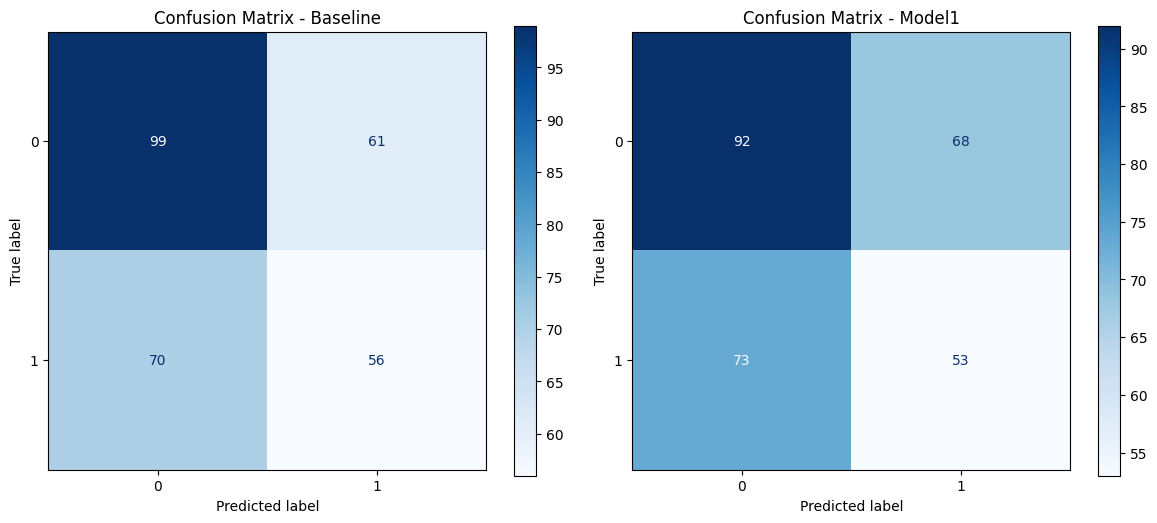

In [ ]:
threshold_baseline = best_params_baseline['classifiation_threshold']
threshold_model1 = best_params_model1['classifiation_threshold']

y_true = test_df['hard_label_task1'].values

#Generate predictions from the Baseline model
y_pred_baseline = best_model_baseline.predict(test_dataset).flatten()
y_pred_baseline_bin = (y_pred_baseline >= threshold_baseline).astype(int)

#Generate predictions from Model1
y_pred_model1 = best_model_1.predict(test_dataset).flatten()
y_pred_model1_bin = (y_pred_model1 >= threshold_model1).astype(int)

#Compute the confusion matrices
cm_baseline = confusion_matrix(y_true, y_pred_baseline_bin)
cm_model1 = confusion_matrix(y_true, y_pred_model1_bin)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

#Baseline
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline,
                                       display_labels=['0', '1'])
disp_baseline.plot(ax=axes[0], cmap=plt.cm.Blues, values_format='d')
axes[0].set_title("Confusion Matrix - Baseline")

# Model1
disp_model1 = ConfusionMatrixDisplay(confusion_matrix=cm_model1,
                                     display_labels=['0', '1'])
disp_model1.plot(ax=axes[1], cmap=plt.cm.Blues, values_format='d')
axes[1].set_title("Confusion Matrix - Model1")

plt.tight_layout()
plt.show()


### Precision/ Recall curve

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


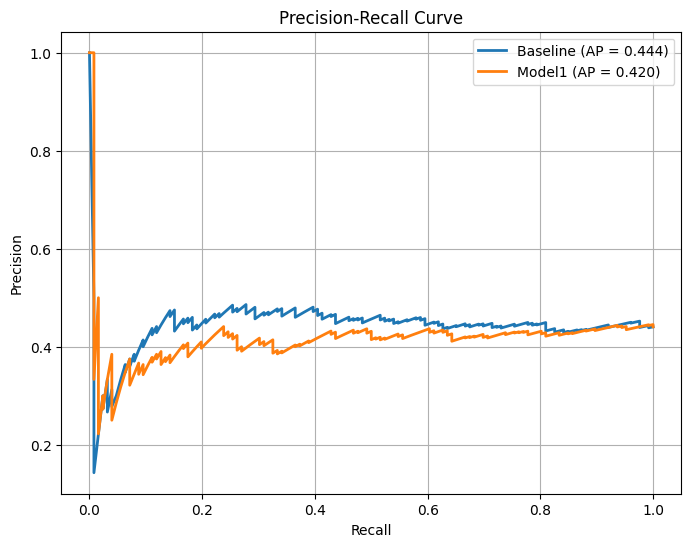

In [ ]:
y_true = test_df["hard_label_task1"].values
#Predicted probabilities for both models
y_pred_baseline = best_model_baseline.predict(test_dataset).flatten()
y_pred_model1 = best_model_1.predict(test_dataset).flatten()

#Compute precision, recall Baseline
precision_baseline, recall_baseline, _ = precision_recall_curve(y_true, y_pred_baseline)

#Compute precision, recall Model1
precision_model1, recall_model1, _ = precision_recall_curve(y_true, y_pred_model1)

#Compute the Average Precision (area under the PR curve)
ap_baseline = average_precision_score(y_true, y_pred_baseline)
ap_model1 = average_precision_score(y_true, y_pred_model1)

plt.figure(figsize=(8, 6))

plt.plot(recall_baseline, precision_baseline, label=f"Baseline (AP = {ap_baseline:.3f})", linewidth=2)
plt.plot(recall_model1, precision_model1, label=f"Model1 (AP = {ap_model1:.3f})", linewidth=2)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid(True)
plt.show()


### Some missclassification examples

*This table is may not be supported in vs code, but it is visible in Google colab*

In [ ]:
threshold = 0.5
pd.set_option('display.max_colwidth', None)

#Convert probabilities to 0/1 predictions
baseline_pred_labels = (y_pred_baseline >= threshold).astype(int)
model1_pred_labels = (y_pred_model1 >= threshold).astype(int)

#Add predictions to the DataFrame
test_df['baseline_pred'] = baseline_pred_labels
test_df['model1_pred'] = model1_pred_labels

#Find misclassified examples for each model
test_df['baseline_misclassified'] = (test_df['baseline_pred'] != test_df['hard_label_task1'])
test_df['model1_misclassified'] = (test_df['model1_pred'] != test_df['hard_label_task1'])

#Filter the DataFrame for misclassifications
baseline_misclassified_df = test_df[test_df['baseline_misclassified'] == True]
model1_misclassified_df = test_df[test_df['model1_misclassified'] == True]

#Print some samples from the misclassified sets
print("Some Baseline misclassifications:")
if not baseline_misclassified_df.empty:
    display(baseline_misclassified_df[['tweet', 'hard_label_task1', 'baseline_pred']].head(10))
else:
    print("No misclassifications found for Baseline.")

print("\nSome Model1 misclassifications:")
if not model1_misclassified_df.empty:
    display(model1_misclassified_df[['tweet', 'hard_label_task1', 'model1_pred']].head(10))
else:
    print("No misclassifications found for Model1.")


Some Baseline misclassifications:


,tweet,hard_label_task1,baseline_pred
400179,"“I like your outfit too except when i dress up as a frigid bitch, i try not to look so constipated” is my new “how are you?”",1,0
400183,"@FernsLewds “Mmm, fuck that cunt is hungry for this dick isn’t it~ Such a shame that you can lie all you want about not wanting this but your body never can~”He says in her ear before he starts kissing down her neck. Making sure to leave plenty of love marks on her pale skin.",1,0
400187,@LogicalFallac18 @LBC Sex* as in 'gender' harassment is what they are inferring.,0,1
400188,"@BBCYaldaHakim Kabul: Islamic Emirate of Afghanistan has announced the end of co-education in the country, citing ""gender harassment"".Female students will attend universities on Monday, Wednesday, and Saturday while Tuesday, Thursday, and Sunday are fixed for males.",1,0
400189,Appreciate being included along with @wphillips49 on the Uvalde gunman’s history of cyber gender harassment. Regrettably unshocking. @UVALaw https://t.co/gg1UwHYdIf,0,1
400192,"""𝐄𝐧𝐠𝐥𝐢𝐬𝐡 𝟏𝟎: Gender, Gender Identity, &amp; Sexual Orientation""Parents place a great deal of trust in the public school system to care for the education of their children.That trust is being betrayed in a shameful and deceitful way.#wednesdaythought https://t.co/H4QBm4wNdG",0,1
400195,"@MrsGreyBull @Miriam2626 Ah! Look! Gender roles are back, too! The don’t believe their own lies.",1,0
400196,@earth2kayla yes hayley hafu representation give our japanese-hispanic girl her flowers,0,1
400197,Isa hot girl summer now pop yall shit https://t.co/bU1bzAUuvr,0,1
400198,My baby called me mommy Sha for the first time today twice!!! Y’all don’t understand how hype that made me. Baby girl has autism and getting her to talk without being prompted has been a challenge. She’s come so far 💕💕💕💕🎉🎉🎉🎉,0,1



Some Model1 misclassifications:


,tweet,hard_label_task1,model1_pred
400179,"“I like your outfit too except when i dress up as a frigid bitch, i try not to look so constipated” is my new “how are you?”",1,0
400189,Appreciate being included along with @wphillips49 on the Uvalde gunman’s history of cyber gender harassment. Regrettably unshocking. @UVALaw https://t.co/gg1UwHYdIf,0,1
400194,"""The violent antifeminism of a far-right movement that sees ♀️ principally as vessels for breeding a new white generation expresses itself in a fixation on a return to “traditional” gender roles""Worth every minute to read - take 5 min out of your Sun👇https://t.co/zkdWPpIlzZ",1,0
400195,"@MrsGreyBull @Miriam2626 Ah! Look! Gender roles are back, too! The don’t believe their own lies.",1,0
400196,@earth2kayla yes hayley hafu representation give our japanese-hispanic girl her flowers,0,1
400197,Isa hot girl summer now pop yall shit https://t.co/bU1bzAUuvr,0,1
400202,@Catoishere @HatClub @RahnniFitteds That gold digger is nice but the picture and set up for them are elite. Pinwork is like the revealing of the Mona Lisa. Always a work of art.,1,0
400203,He Tries To Expose This Gold Digger BUT IT BACKFIRES. | 90 Day Fiancée B... https://t.co/pz91AbJ0WS via @YouTube,0,1
400204,@RonFilipkowski Not enough is made of the fact that she’s an unabashed gold digger. 🤷🏻‍♂️,1,0
400205,@MatrixPirate12 Well let me ask for the guys… do you ever just grab your testicles because you can?,0,1


#Analysis of Misclassified Tweets from the Baseline Model
The baseline model misclassified several tweets, and a detailed analysis of these examples reveals several key patterns that the model struggled to correctly classify. Below are the key challenges observed from the provided misclassified tweets.

1. Tweets with Offensive or Explicit Language
The baseline model struggled with tweets containing offensive or explicit language, which often led to incorrect predictions. The model might have associated these words with negative sentiment or harassment without understanding the broader context.

Example tweet:

"@FernsLewds 'Mmm, fuck that cunt is hungry for this dick isn’t it~' Such a shame that you can lie all you want about not wanting this but your body never can~' He says in her ear before he starts kissing down her neck. Making sure to leave plenty of love marks on her pale skin."

These types of tweets may use explicit language in different contexts (such as storytelling or humor), which the model failed to interpret correctly.

2. Tweets Discussing Gender and Harassment
The baseline model also struggled to correctly classify tweets discussing gender roles, harassment, or gender identity topics. These tweets often contain subtle language and require a deeper understanding of social and cultural issues, which the baseline model lacked.

Example tweets:

"@BBCYaldaHakim Kabul: Islamic Emirate of Afghanistan has announced the end of co-education in the country, citing 'gender harassment'. Female students will attend universities on Monday, Wednesday, and Saturday while Tuesday, Thursday, and Sunday are fixed for males."

"@LogicalFallac18 @LBC Sex* as in 'gender' harassment is what they are inferring."

These tweets involve societal and political context, which can be challenging for models without context-aware embeddings.

3. Tweets with Sarcasm and Irony
The baseline model showed difficulty in detecting sarcasm or irony in tweets. These tweets often involve a playful or rhetorical tone, which surface-level text analysis often fails to capture.

Example tweet:

"I like your outfit too except when I dress up as a frigid bitch, I try not to look so constipated is my new 'how are you?'"

Sarcasm requires an understanding of tone and implied meaning beyond the literal text, which the baseline model struggled to achieve.

4. Tweets with Complex and Contextual Language
Some tweets contained complex structures or required external context to interpret correctly. The baseline model struggled with these types of tweets as well.

Example tweet:

"English 10: Gender, Gender Identity, & Sexual Orientation. Parents place a great deal of trust in the public school system to care for the education of their children. That trust is being betrayed in a shameful and deceitful way. #wednesdaythought"

Such tweets often have nuanced meanings or multiple layers of interpretation, which the baseline model may not be equipped to handle.

5. Tweets with Informal Language or Personal Anecdotes
The model also misclassified tweets that were informal or personal in nature. These tweets often contain emotional content or personal anecdotes, making them harder for the model to classify correctly.

Example tweet:

"My baby called me mommy Sha for the first time today twice!!! Y’all don’t understand how hype that made me. Baby girl has autism and getting her to talk without being prompted has been a challenge. She’s come so far 🥹❤️❤️❤️❤️❤️❤️🐦🐦🐦🐦🐦🐦"

Tweets like this involve emotional storytelling and personal experiences, which may be challenging for the baseline model to classify correctly due to its focus on more surface-level patterns.

Analysis of Misclassified Tweets from Model 1
The analysis of misclassified tweets from Model 1 reveals several key patterns where the model struggled to classify tweets correctly. Below are the primary challenges observed along with example tweets:

1. Tweets with Gender-Related Topics and Harassment
Model 1 struggled to correctly classify tweets that discuss gender roles, gender harassment, or gender identity. These topics often require a nuanced understanding of cultural and societal context, which the model may lack.

Example tweet:

"Appreciate being included along with @wphillips49 on the Uvalde gunman’s history of cyber gender harassment. Regrettably unshocking. @UVALaw https://t.co/gg1UwHYdIf"

2. Tweets with Complex Sentences and Contextual Language
The model had difficulty interpreting tweets with long sentences or academic language that require understanding beyond simple keyword detection.

Example tweet:

""The violent antifeminism of a far-right movement that sees women principally as vessels for breeding a new white generation expresses itself in a fixation on a return to 'traditional' gender roles. Worth every minute to read - take 5 min out of your Sun 🌞 https://t.co/zdKWpplIZz\""

3. Tweets with Sarcasm or Ambiguity
Model 1 struggled to detect sarcasm and ambiguous language. Sarcastic tweets often have an implicit meaning that models may not recognize, leading to misclassifications.

Example tweet:

"@LogicalFallac18 @LBC Sex* as in 'gender' harassment is what they are inferring."

4. Tweets Discussing Violence or Harsh Topics
Tweets discussing violence or harsh realities were often misclassified by the model. These tweets can be interpreted as offensive or inappropriate, even when they are factual statements.

Example tweet:

"@RonFilipkowski Not enough is made of the fact that she’s an unabashed gold digger."

5. Tweets with Informal Language or Slang
Model 1 also struggled to classify tweets containing informal language, slang, or colloquial expressions. These variations of informal speech may not be well-represented in the training data.

Example tweet:

"@MatrixPirate12 Well let me ask for the guys... do you ever just grab your testicles because you can?"

## Transformer Model

### Table of **results**

*This table is may not be supported in vs code, but it is visible in Google colab*

In [ ]:
import pandas as pd

# Create a list of dictionaries to hold model data
models_data = [
    {
        "model": "Transformer",
        "val_f1": val_f1,
        "test_f1": test_f1,
        "learning_rate": 5e-05,
        "batch_size": 8,
        "num_train_epochs": 6,
    }
]


df = pd.DataFrame(models_data)
display(
    df.style.format(
        {
            "val_f1_mean": "{:.4f}",
            "val_f1_std": "{:.4f}",
            "test_f1_mean": "{:.4f}",
            "test_f1_std": "{:.4f}",
        }
    )
)


,model,val_f1,test_f1,learning_rate,batch_size,num_train_epochs
0,Transformer,0.881203,0.851513,0.000050,8,6


### Confusion Matrix

<ipython-input-7-b80ce5a4df69>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


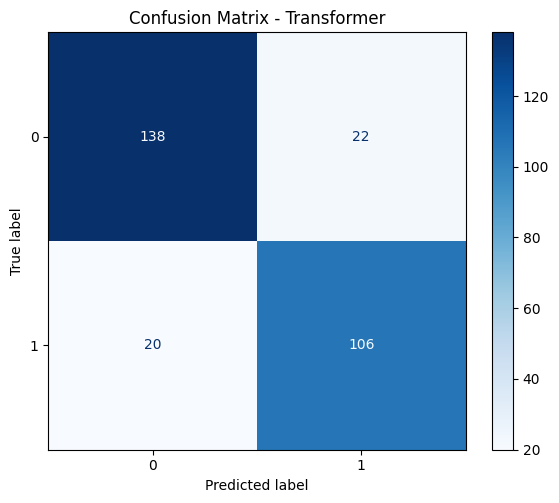

In [ ]:

threshold_transformer = 0.5  

predictions = trainer.predict(test_dataset)
y_pred_transformer = predictions.predictions[:, 1]

y_pred_transformer_bin = (y_pred_transformer >= threshold_transformer).astype(int)

y_true = test_df['hard_label_task1'].values

cm_transformer = confusion_matrix(y_true, y_pred_transformer_bin)

fig, ax = plt.subplots(figsize=(6, 5))
disp_transformer = ConfusionMatrixDisplay(confusion_matrix=cm_transformer,
                                          display_labels=['0', '1'])
disp_transformer.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
ax.set_title("Confusion Matrix - Transformer")

plt.tight_layout()
plt.show()


### Precision Recall curve

<ipython-input-7-b80ce5a4df69>:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


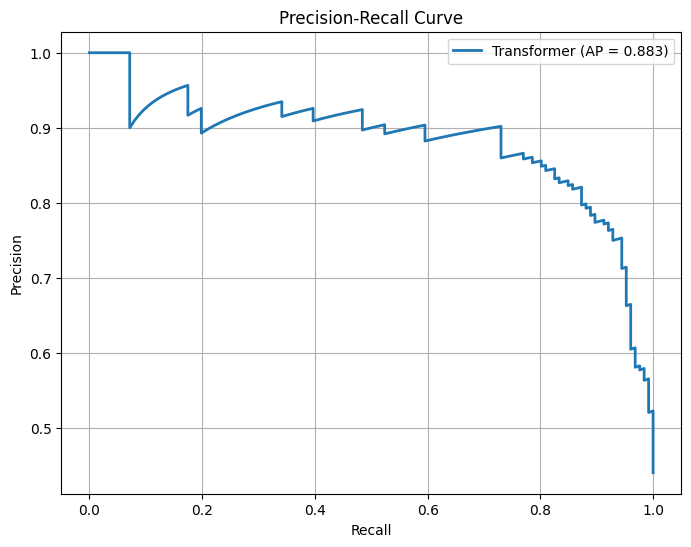

In [ ]:

y_true = test_df["hard_label_task1"].values


predictions = trainer.predict(test_dataset)
y_pred_transformer = predictions.predictions[:, 1]
precision_transformer, recall_transformer, _ = precision_recall_curve(y_true, y_pred_transformer)
ap_transformer = average_precision_score(y_true, y_pred_transformer)

plt.figure(figsize=(8, 6))

# Plot for Transformer
plt.plot(recall_transformer, precision_transformer, label=f"Transformer (AP = {ap_transformer:.3f})", linewidth=2)

# Plot settings
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid(True)
plt.show()


### Missclassified Examples

*This table is may not be supported in vs code, but it is visible in Google colab*

In [ ]:
threshold = 0.5

# Convert Transformer model predictions to binary labels based on the threshold
transformer_pred_labels = (y_pred_transformer >= threshold).astype(int)

# Add the predictions to the DataFrame
test_df['transformer_pred'] = transformer_pred_labels

# Identify misclassified examples by comparing predictions with hard labels
test_df['transformer_misclassified'] = (test_df['transformer_pred'] != test_df['hard_label_task1'])

# Filter the DataFrame to only show misclassified examples
transformer_misclassified_df = test_df[test_df['transformer_misclassified'] == True]

print("Some Transformer Misclassifications:")
if not transformer_misclassified_df.empty:
    pd.set_option('display.max_colwidth', None)

    display(transformer_misclassified_df[['tweet', 'hard_label_task1', 'transformer_pred']].head(10))
else:
    print("No misclassifications found for Transformer.")


Some Transformer Misclassifications:


,tweet,hard_label_task1,transformer_pred
400185,"“I mean I do, but… wouldn’t it be fun to get gangbanged together~?” https://t.co/lNRZ9z53VL",0,1
400187,@LogicalFallac18 @LBC Sex* as in 'gender' harassment is what they are inferring.,0,1
400188,"@BBCYaldaHakim Kabul: Islamic Emirate of Afghanistan has announced the end of co-education in the country, citing ""gender harassment"".Female students will attend universities on Monday, Wednesday, and Saturday while Tuesday, Thursday, and Sunday are fixed for males.",1,0
400189,Appreciate being included along with @wphillips49 on the Uvalde gunman’s history of cyber gender harassment. Regrettably unshocking. @UVALaw https://t.co/gg1UwHYdIf,0,1
400194,"""The violent antifeminism of a far-right movement that sees ♀️ principally as vessels for breeding a new white generation expresses itself in a fixation on a return to “traditional” gender roles""Worth every minute to read - take 5 min out of your Sun👇https://t.co/zkdWPpIlzZ",1,0
400199,@EyemotionFandom How did we reach a point where blonks are having the audacity to talk about yoongis rap do y'all see who you Stan ? Are y'all ok ?? Your girls can't write can't deliver can't come close to bts's lyricism tf are y'all getting brave for ?? Fashion deals ??,0,1
400202,@Catoishere @HatClub @RahnniFitteds That gold digger is nice but the picture and set up for them are elite. Pinwork is like the revealing of the Mona Lisa. Always a work of art.,1,0
400203,He Tries To Expose This Gold Digger BUT IT BACKFIRES. | 90 Day Fiancée B... https://t.co/pz91AbJ0WS via @YouTube,0,1
400205,@MatrixPirate12 Well let me ask for the guys… do you ever just grab your testicles because you can?,0,1
400237,@BoopBepp @Helloth07860784 @Bronwen85 Yup I hate when men rape and kill women. https://t.co/MyfVPu6THd,0,1


#Analysis of Misclassified Tweets from the Transformer Model
The analysis of misclassified tweets from the Transformer model reveals several key patterns where the model struggled to correctly classify tweets. Below are the primary challenges observed along with example tweets:

1. Tweets with Gender-Related Topics and Harassment
The Transformer model struggled to correctly classify tweets discussing gender roles, gender harassment, or women's rights. These tweets often contain nuanced language or societal context that the model may not fully understand.

Example tweet:

"@BBCYaldaHakim Kabul: Islamic Emirate of Afghanistan has announced the end of co-education in the country, citing 'gender harassment'. Female students will attend universities on Monday, Wednesday, and Saturday while Tuesday, Thursday, and Sunday are fixed for males."

2. Tweets with Complex Sentences and Contextual Language
The model struggled with tweets containing long, complex sentences or academic language that require a deeper understanding of the context.

Example tweet:

""The violent antifeminism of a far-right movement that sees women principally as vessels for breeding a new white generation expresses itself in a fixation on a return to 'traditional' gender roles. Worth every minute to read - take 5 min out of your Sun.""

3. Tweets with Sarcasm or Ambiguity
Tweets containing sarcasm or ambiguity were often misclassified by the model. These tweets require an understanding of tone and implicit meaning, which can be difficult for the model to detect.

Example tweet:

"I mean I do, but... wouldn't it be fun to get gangbanged together~?"

4. Tweets Discussing Violence or Harsh Topics
The Transformer model struggled with tweets discussing violence or harsh realities. Such tweets may be interpreted as offensive or inappropriate, even if they are factual statements.

Example tweet:

"@BoopBepp @Helloth07860784 @Bronwen85 Yup I hate it when men rape and kill women."

5. Tweets with Informal Language or Slang
The model also struggled with tweets containing informal language, slang, or colloquial expressions. These variations of informal speech may not be well-represented in the training data.

Example tweet:

"@MatrixPirate12 Well let me ask for the guys... do you ever just grab your testicles because you can?"

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).
However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Extensions/Explorations for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.







# The End